# Introduction

Forecasting enrollment for individual classes is important for departments and colleges at universities. It allows them to properly prepare adequate resources for students, such as: hiring the right number of TAs, offering the correct number of sections for classes, and assigning classes to the proper lecture halls. Needless to say, forecasting accurately the number of students signing up for a particular class is of high interest and need. Additionally, if possible, understanding the driving factors behind why certain classes are more popular or which classes are the most variable semester-to-semester is of particular interest. 

We demonstrate in this post the power of Bayesian forecasting, utilizing a two-part model. The first part forecasts the percent change in enrollment for the upcoming semester compared to the previous semester. The second part forecasts the percent change in percent share of total enrollment at Texas A&M University. 

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pmdarima

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from xgboost import XGBRegressor

import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

/home/thebscotte/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Read in R data
result = pyreadr.read_r('enrollment_proj_685.RData')

In [3]:
#| include: false

#Show names of dataframes
result.keys()

odict_keys(['grades_all', 'UIN_dta', 'admits_co', 'admits_mj', 'target_co_FR', 'target_co_TR', 'target_mj_AT_FR', 'target_mj_AT_TR', 'major_college', 'course_college'])

# EDA

We begin our analysis by viewing the scope of the data we will be working with. Below is a print out of all dataframes offered to us.

In [4]:
#Get shape for each dataframe
for key in result.keys():
    print(f"dataframe: {key} {result[key].shape}")

dataframe: grades_all (1060795, 9)
dataframe: UIN_dta (154081, 30)
dataframe: admits_co (12, 7)
dataframe: admits_mj (22, 7)
dataframe: target_co_FR (12, 2)
dataframe: target_co_TR (9, 2)
dataframe: target_mj_AT_FR (42, 2)
dataframe: target_mj_AT_TR (42, 2)
dataframe: major_college (186, 3)
dataframe: course_college (278, 2)


The above output shows we have 10 dataframes to possibly work with, with the first two containing a fairly large amount of data. From this, we can gather that a lot of data preparation and cleaning may be necessary before proceeding with analysis and model creation. A good way to approach this is by viewing the dataframes individually and gaining an understanding of what each contains. Below is a `head` method call on the grades_all dataframe. 

In [5]:
#Look at grades all
result['grades_all'].head()

,UIN,Subject,Course_Number,Quality_Points,Course_Credits,Final_Grade,Course_Section,Status,TERM
0,1,EHRD,374.0,12.0,3.0,A,599,RW,20213.0
1,1,EHRD,477.0,12.0,3.0,A,599,RW,20213.0
2,2,MKTG,409.0,9.0,3.0,B,599,RW,20213.0
3,3,POLS,206.0,12.0,3.0,A,510,RW,20213.0
4,3,AGLS,235.0,12.0,3.0,A,599,RW,20213.0


From the above output, we see that there are 9 columns of data. UIN is a unique identifier for each student on campus (annonymized). Each of the other columns appear to be self-explanatory. TERM refers to the year the class was taken and the last digit (furthest left before the decimal) is the indicator of fall or spring term (3 being fall and 1 being spring). 

To get a better idea of how many grades we have by term, we can use the `groupby` method. The result is shown below.

In [6]:
#| include: false

#Get number of each letter grade
result['grades_all'].groupby(['Final_Grade']).size()

Final_Grade
A     371552
B     200848
C      88656
D      19485
F      12006
I       2008
IP    282308
NG        23
Q      30608
S      42657
U       1288
W       7278
X       2078
dtype: int64

In [7]:
#Get number of each letter grade by term
result['grades_all'].groupby(['TERM', 'Final_Grade']).size()

TERM     Final_Grade
20213.0  A              122510
         B               68995
         C               30641
         D                6734
         F                4389
         I                 858
         Q               10932
         S               16483
         U                 457
         W                2869
         X                1721
20221.0  A              114925
         B               62317
         C               28265
         D                6157
         F                3728
         I                 543
         NG                  6
         Q                9584
         S                9831
         U                 297
         W                2103
         X                 236
20223.0  A              132700
         B               69269
         C               29699
         D                6589
         F                3870
         I                 606
         IP                  1
         NG                 17
         Q        

Taking a quick glance at the data, there appears to be a steady number of grades by term up till 2023. Spring 2023 appears to have very few grades in comparison to other terms. Fall 2023 picks back up with the number of grades, but most of them are IP (in progress). 

In [8]:
#| include: false

#Look at admits_co
result['admits_co'].head()

,COLLEGE,ADM_23,ADM_22,ADM_21,CON_23,CON_22,CON_21
0,AC,512,376,346,317,225,225
1,AG,2618,1889,2102,1345,922,1006
2,AT,7093,6385,6872,2549,2409,2528
3,BA,2348,2025,2160,1116,1080,1184
4,ED,1166,843,881,521,373,398


We can proceed to viewing more of the dataframes, like the UIN_dta. The `head` method on the UIN_dta dataframe yields the below result.

In [9]:
#Look at UIN_dta
result['UIN_dta'].head()

,UIN,PROG_CURR,COLL_CURR,PROG_ADM,COLL_ADM,TERM_LAST,TERM_ADM,TERM_CHG,ADM,DEG_CURR,...,CM_ADM,YEAR_CHG,SEM_CHG,CM_CHG,FLAG,TERM_TOCS,YEAR_TOCS,SEM_TOCS,MAJOR_TOCS,TO_CS
0,1.0,BS-HRDV,ED,BS-HRDL,ED,202231.0,201831.0,201911.0,TR,BS,...,1.0,2019.0,1.0,1.0,0.0,NaN,NaN,NaN,,0.0
1,89768.0,BS-VISL,PV,BS-VISL,PV,202031.0,202031.0,202031.0,FR,BS,...,1.0,2020.0,3.0,1.0,0.0,NaN,NaN,NaN,,0.0
2,89769.0,BS-RLEM-RMO,AG,BS-RLEM,AG,202031.0,201911.0,201911.0,TR,BS,...,1.0,2019.0,1.0,1.0,0.0,NaN,NaN,NaN,,0.0
3,3.0,BA-USLA-SEL,AT,BA-USLA-SEL,AT,202331.0,202111.0,202111.0,FR,BA,...,1.0,2021.0,1.0,1.0,0.0,NaN,NaN,NaN,,0.0
4,89770.0,BBA-MISY,BA,BS-AGBL,AG,202111.0,201731.0,201911.0,FR,BBA,...,1.0,2019.0,1.0,1.0,0.0,NaN,NaN,NaN,,0.0


The UIN_dta dataframe contains 30 columns of data. This dataframe, like the grades_all dataframe, contains a UIN column (perhaps will be useful for mapping data points). Additionally, this dataframe contains many other useful additional features about students. 

To get a general idea if enrollment is growing by semester, we can plot out a time series plot to see the change over time of new admits for each term. Below in @fig-enroll-1 we see this result.

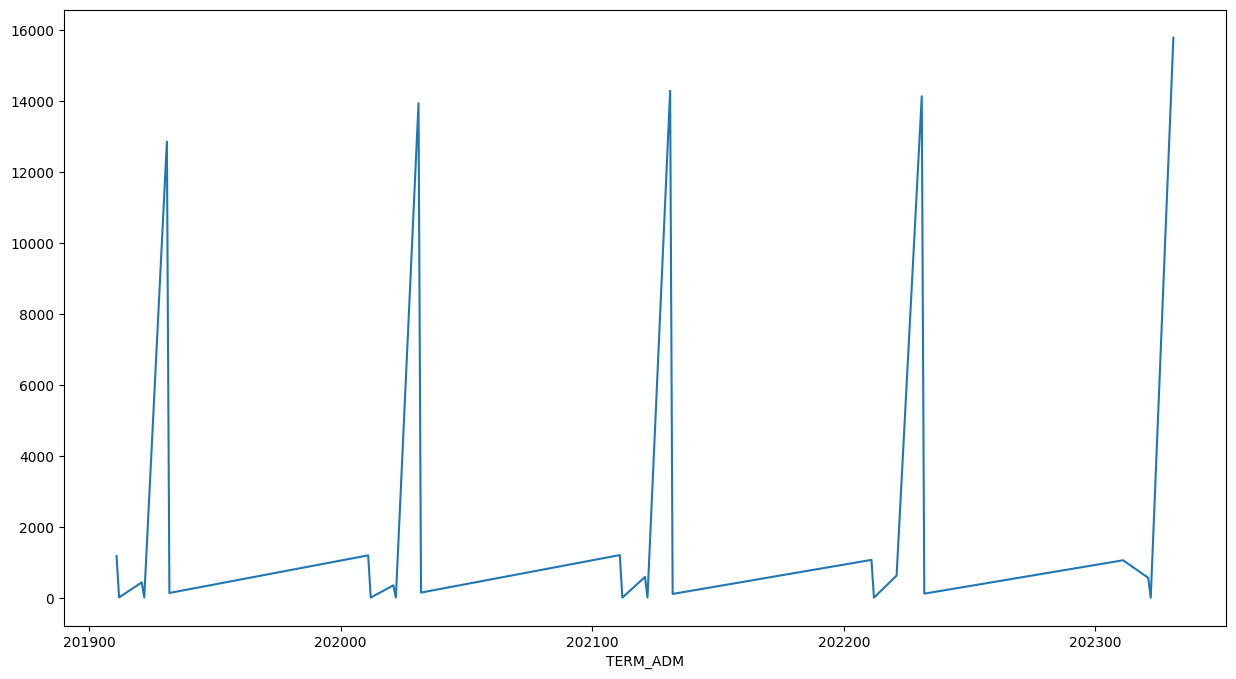

In [10]:
#| label: fig-enroll-1
#| fig-cap: "Number of new students admitted (and enrolled) by term"

#Get counts of number of students over time based on term_adm from the past 5 years
(result['UIN_dta'].query("TERM_ADM >= 202333.0 - 500")
 .groupby(['TERM_ADM'])
 .size()
 .plot(figsize=(15,8)));

The spikes appear to be during the fall terms, which makes sense since most students begin their college career in the fall. We can continue to investigate this area further in the analysis.

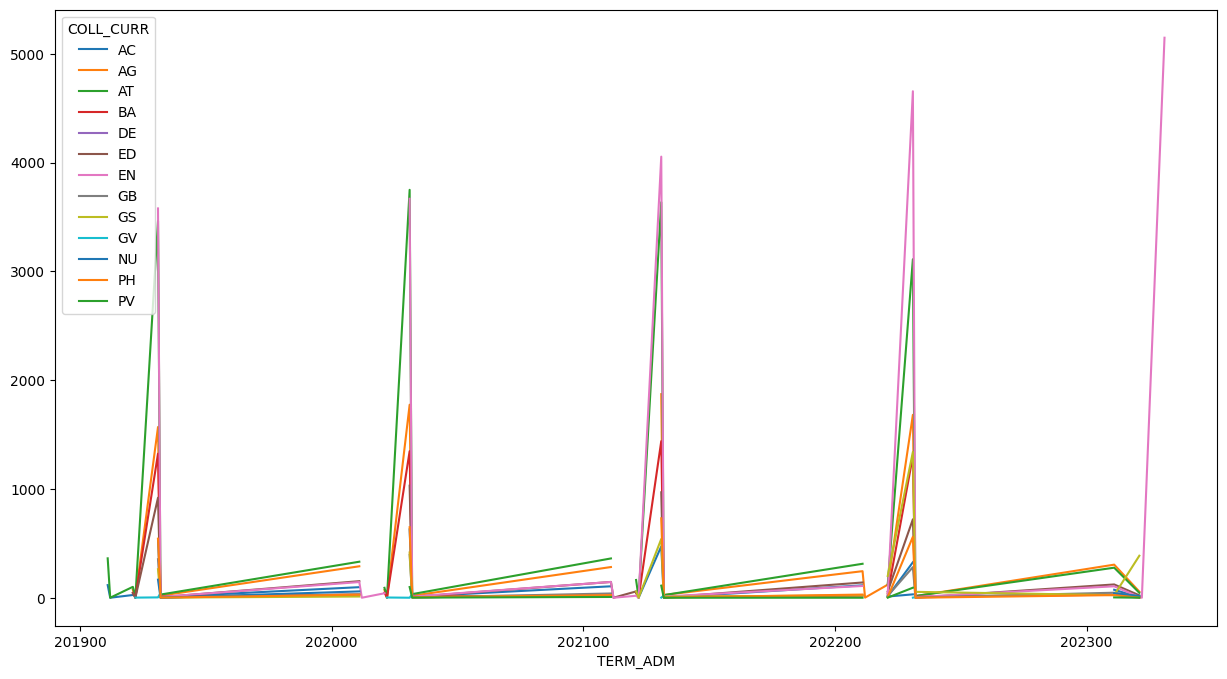

In [11]:
#| include: false

#Get counts of each coll_curr based on term_adm from past 5 years
(result['UIN_dta'].query("TERM_ADM >= 202333.0 - 500")
 .groupby(['TERM_ADM', 'COLL_CURR'])
 .size()
 .reset_index()
 .rename(columns={0:'counts'})
 .pivot_table(values='counts', index='TERM_ADM', columns='COLL_CURR')
 .plot(figsize=(15,8)));

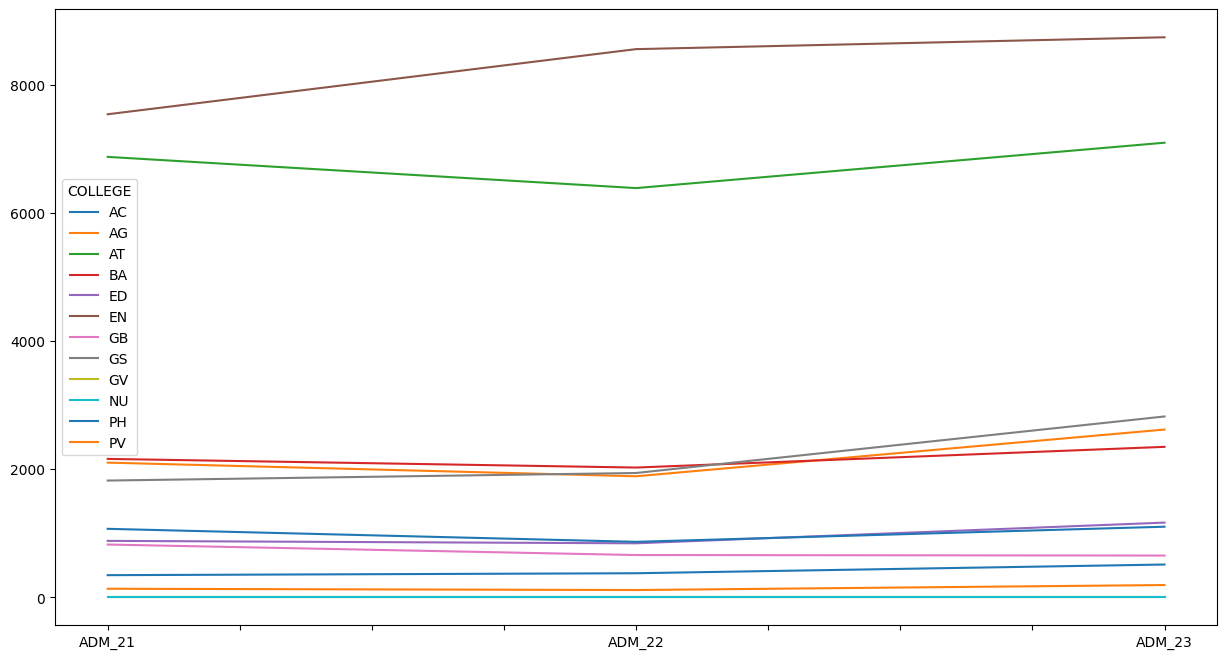

In [12]:
#| include: false

#Look at recent admit numbers for each college
(result['admits_co'].drop(['CON_23', 'CON_22', 'CON_21'], axis=1)
 .pivot_table(columns='COLLEGE')
 .plot(figsize=(15,8)));

Proceeding with exploring the various dataframes, we can list out how many unique subjects there are from our grades_all dataframe. The results are shown below.

In [13]:
#List out unique subjects
result['grades_all']['Subject'].unique()

array(['EHRD', 'MKTG', 'POLS', 'AGLS', 'COMM', 'ITAL', 'MATH', 'FYEX',
       'CHEM', 'BIMS', 'CHIN', 'HIST', 'SPMT', 'MGMT', 'BUSN', 'PHYS',
       'CSCE', 'MEEN', 'ENGL', 'JAPN', 'PERF', 'SOCI', 'MMET', 'MSEN',
       'STAT', 'PBSI', 'WGST', 'ATMO', 'ENGR', 'FINC', 'TCMG', 'WFSC',
       'ECEN', 'ISEN', 'ENTO', 'HLTH', 'ARCH', 'URPN', 'GEOG', 'MUSC',
       'ECON', 'NUTR', 'BIOL', 'FSTC', 'ACCT', 'PHIL', 'KINE', 'ANTH',
       'SOMS', 'AGSC', 'ANSC', 'ESSM', 'RPTS', 'GEOL', 'COSC', 'PHLT',
       'GENE', 'AGEC', 'AERO', 'ARTS', 'SCSC', 'NUEN', 'POSC', 'ALED',
       'INTS', 'FILM', 'CVEN', 'BICH', 'NRSC', 'SCMT', 'NVSC', 'VIBS',
       'ISTM', 'SCEN', 'VTPB', 'FREN', 'HORT', 'ASCC', 'RDNG', 'INST',
       'MASC', 'CLEN', 'RELS', 'AFST', 'IDIS', 'ESET', 'JOUR', 'LING',
       'OCNG', 'ASTR', 'EPSY', 'RUSS', 'PLPA', 'VIST', 'BMEN', 'OCEN',
       'NURS', 'TEFB', 'TEED', 'SPAN', 'CLSC', 'CHEN', 'AGSM', 'CLAS',
       'AREN', 'EDCI', 'BESC', 'AGCJ', 'ECMT', 'MXET', 'GERM', 'SENG',
      

Additionally, we can view the most popular courses by semester. Below, we list the top 10 courses from each term and subsequently rank them by largest to smallest over the entire time frame of our dataset.

In [14]:
#Get top 10 most popular courses by term, subject, and course number

#Initialize querying parameters
custom_subjects = ['ENGR', 'STAT']
custom_terms = [20233.0]

#Perform chaining
(result['grades_all'].groupby(['TERM', 'Subject'])['Course_Number']
 .value_counts()
 .reset_index()
 .groupby(['TERM', 'Subject'])[['Course_Number', 'count']]
 .apply(lambda x: x.nlargest(10, 'count'))
 .reset_index()
 .drop(columns=['level_2'], axis=1)
 .sort_values(by=['count'], ascending=False)
 .head(25)
)

,TERM,Subject,Course_Number,count
4097,20233.0,ENGR,102.0,5470
2857,20223.0,ENGR,102.0,5433
416,20213.0,ENGR,102.0,4963
4207,20233.0,FYEX,101.0,4904
2968,20223.0,FYEX,101.0,4827
3385,20223.0,POLS,207.0,4602
531,20213.0,FYEX,101.0,4511
948,20213.0,POLS,207.0,4464
4419,20233.0,MATH,140.0,4394
4634,20233.0,POLS,207.0,4167


From the table above, we can see that ENGR 102 appears to be the most popular course over all time and even continues to have a growth. FYEX is a first year experience course so it appears that many freshmen take the course. 

The information above can be utilized even further, by seeing if there were ever any large discrepancies in the number of students between two semesters. Due to the large amount of data, we will focus on one subject to view. Below in @fig-diff-enroll, we see the difference over time between two semesters (current semester class enrollment - past semester class enrollment). 

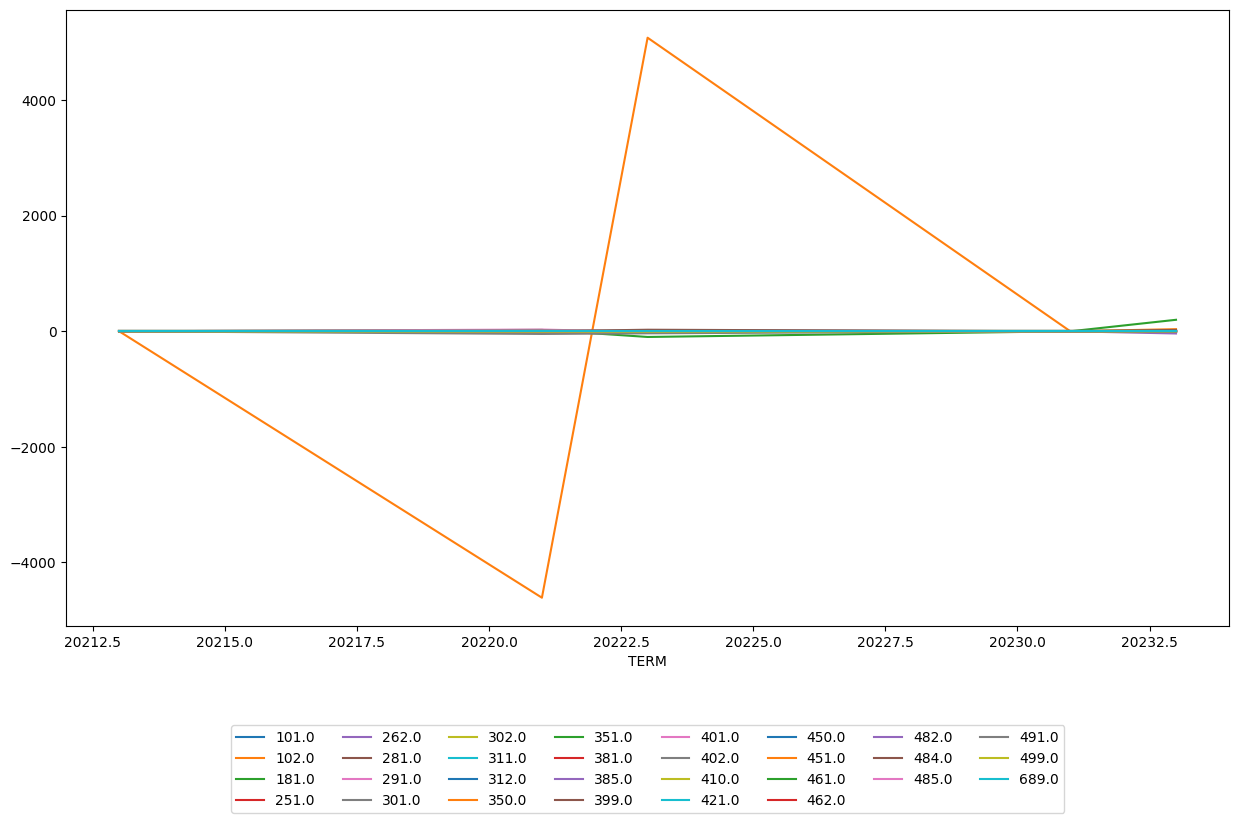

In [15]:
#| label: fig-diff-enroll
#| fig-cap: "Difference in enrollment of current vs previous semester for ENGR classes"

#Determine if each subject course-number combination has more or less students than previous term (calculate difference)
ax = (result['grades_all'].groupby(['TERM', 'Subject'])['Course_Number']
 .value_counts()
 .reset_index()
 .sort_values(by=['Course_Number', 'Subject', 'TERM'])
 .assign(diff_term = lambda x: np.where((x['Subject'] == x['Subject'].shift(1)) & (x['TERM'] != x['TERM'].shift(1)), 
                                        x['count'] - x['count'].shift(1), 0))
 .sort_values(by='TERM')
 .pivot_table(index='TERM', values='diff_term', columns=['Subject', 'Course_Number'])
 .fillna(0)['ENGR']
 .plot(figsize=(15,8))
)

ax.legend(loc='upper center', ncol=8, bbox_to_anchor=(0.5, -0.15));

Such a large difference between two semesters, as shown in @fig-diff-enroll, definitely merits a closer look to ensure that our graph properly calculated such a difference. Below is a tabular view of what we see above for ENGR 102. 

In [16]:
#Check why 102 has such a big difference
(result['grades_all'].groupby(['TERM', 'Subject'])['Course_Number']
 .value_counts()
 .reset_index()
 .sort_values(by=['Course_Number', 'Subject', 'TERM'])
 .assign(diff_term = lambda x: np.where((x['Subject'] == x['Subject'].shift(1)) & (x['TERM'] != x['TERM'].shift(1)), 
                                        x['count'] - x['count'].shift(1), 0))
 .query("Subject == 'ENGR' and Course_Number == 102.0")
)

,TERM,Subject,Course_Number,count,diff_term
949,20213.0,ENGR,102.0,4963,0.0
3460,20221.0,ENGR,102.0,353,-4610.0
6098,20223.0,ENGR,102.0,5433,5080.0
8706,20233.0,ENGR,102.0,5470,37.0


For some reason, in spring 2022, there was a huge drop in enrollment for ENGR 102. One possible reason is that most of the people interested in such a course already took it in the fall to prepare for the next class that is only offered in the spring. We assume this hypothesis due to the elimination of ENGR 102 in the following spring. Perhaps this was noticed by university administration and to properly allocate resources, decided to drop the spring offering of ENGR 102. 

This also presents a possible new challenge with our data. Assuming our above hypothesis is true, classes can be dropped from university offering due to lack of interest. We will need to account for this possible phenemenon in our model when we begin that process.

@fig-diff-enroll shows that for the most part, most classes are fairly consistent in their enrollment numbers (at least in ENGR), with exception to ENGR 102. ENGR 102, as we noted above, is consistently one of the largest classes on campus and thus we would have a larger amount of variation compared to smaller classes found in ENGR. We can generalize this approach of viewing variance of subjects by calculating the most variable classes based on their respective diff_term calculation that we performed above. The result of this is shown below in @fig-var-enroll

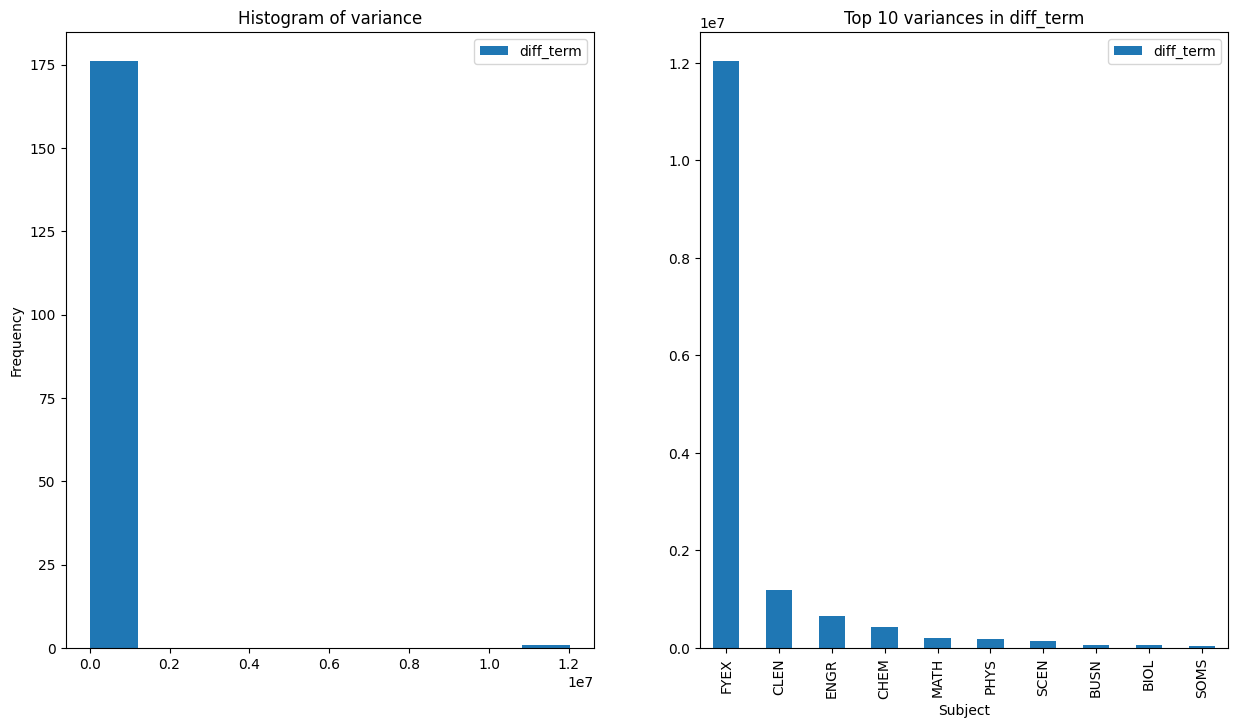

In [17]:
#| label: fig-var-enroll
#| fig-cap: "Left-hand panel shows variance across all diff_term calculations. The histogram shows that most classes have minimum variation but that there are large variances found in the data. The right-hand panel shows the top 10 variances in diff_term."

#Create subplots
fig, axes = plt.subplots(1,2, figsize=(15,8))

#Calculate variance for each subject diff_term
(result['grades_all'].groupby(['TERM', 'Subject'])['Course_Number']
 .value_counts()
 .reset_index()
 .sort_values(by=['Course_Number', 'Subject', 'TERM'])
 .assign(diff_term = lambda x: np.where((x['Subject'] == x['Subject'].shift(1)) & (x['TERM'] != x['TERM'].shift(1)), 
                                        x['count'] - x['count'].shift(1), 0))
 .groupby(['Subject'])['diff_term']
 .var()
 .fillna(0)
 .sort_values(ascending=False)
 .reset_index()
 .plot(kind='hist', ax=axes[0], title='Histogram of variance')
)

(result['grades_all'].groupby(['TERM', 'Subject'])['Course_Number']
 .value_counts()
 .reset_index()
 .sort_values(by=['Course_Number', 'Subject', 'TERM'])
 .assign(diff_term = lambda x: np.where((x['Subject'] == x['Subject'].shift(1)) & (x['TERM'] != x['TERM'].shift(1)), 
                                        x['count'] - x['count'].shift(1), 0))
 .groupby(['Subject'])['diff_term']
 .var()
 .fillna(0)
 .sort_values(ascending=False)
 .reset_index()
 .head(10)
 .plot(kind='bar', x='Subject', y='diff_term', ax=axes[1], title='Top 10 variances in diff_term')
);

The left-hand panel in @fig-var-enroll shows that the great majority of courses have the same variance (relatively speaking) with the exception to some very large variance outliers. These large outliers are probably from other large classes (like ENGR 102). The right-hand panel shows us which subjects are the highest ones. It is not suprising, once again, that many of these subjects were also part of the largest classes table. 

In [18]:
#| include: false

#Look at popular freshmen courses from 2021-present
(pd.merge(result['grades_all'], result['course_college'], how='inner', left_on='Subject', right_on='Subject')
 .merge(result['UIN_dta'][['UIN', 'TERM_ADM']], how='inner', left_on='UIN', right_on='UIN')
 .query("TERM_ADM >= 202111.0")
 .assign(TERM_ADM_edited = lambda x: x['TERM_ADM'] * .1)
 .assign(fresh_year = lambda x: np.where(x['TERM'] - x['TERM_ADM_edited'] <= 3, 1, 0))
 .groupby(['College', 'Subject', 'Course_Number'])['fresh_year'].sum()
 .reset_index()
 .query("fresh_year > 0")
 .sort_values(by=['fresh_year'], ascending=False)
 .head(30)
)

,College,Subject,Course_Number,fresh_year
2369,EN,ENGR,102.0,14444
2769,GS,FYEX,101.0,14302
1376,AT,MATH,140.0,9935
853,AT,CHEM,119.0,9782
1381,AT,MATH,151.0,8037
2703,GB,POLS,207.0,7488
851,AT,CHEM,107.0,6934
852,AT,CHEM,117.0,6932
809,AT,BIOL,111.0,6465
2225,EN,CLEN,181.0,5998


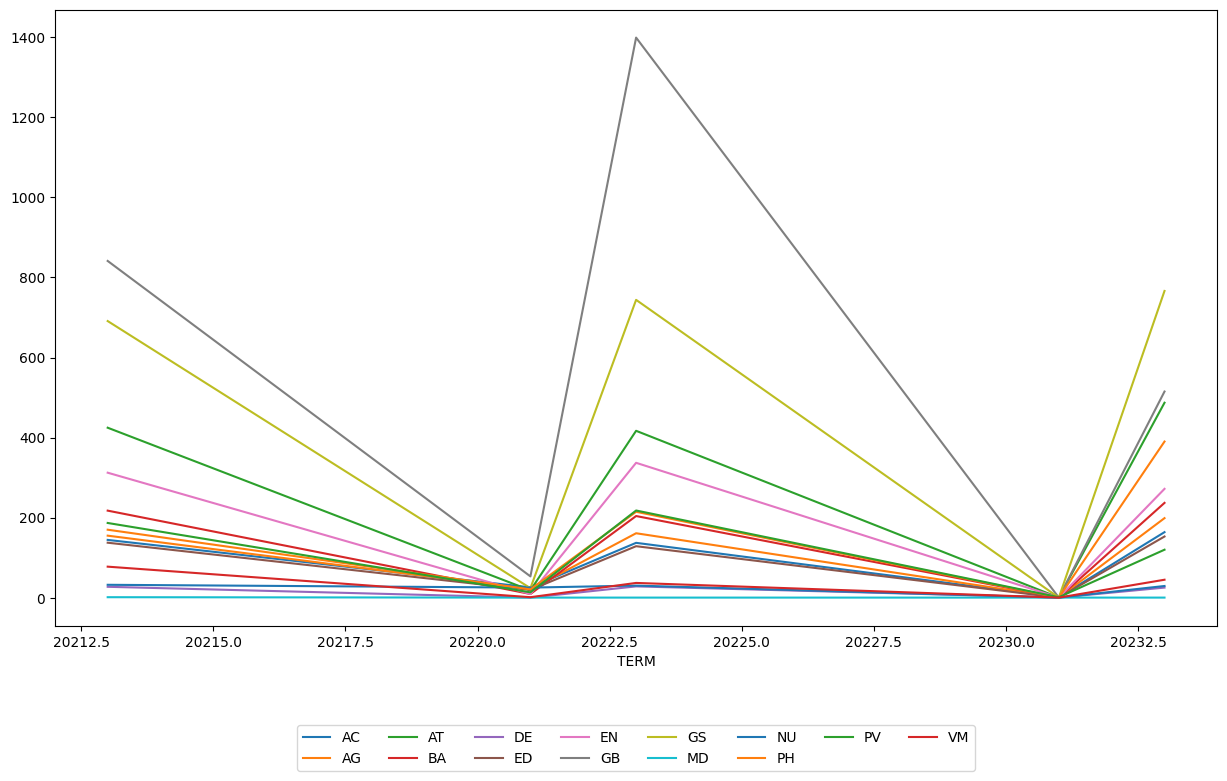

In [19]:
#| include: false

#Look at time series view of popular freshmen courses by college
ax = (pd.merge(result['grades_all'], result['course_college'], how='inner', left_on='Subject', right_on='Subject')
 .merge(result['UIN_dta'][['UIN', 'TERM_ADM']], how='inner', left_on='UIN', right_on='UIN')
 .query("TERM_ADM >= 202111.0")
 .assign(TERM_ADM_edited = lambda x: x['TERM_ADM'] * .1)
 .assign(fresh_year = lambda x: np.where(x['TERM'] - x['TERM_ADM_edited'] <= 3, 1, 0))
 .groupby(['TERM', 'College', 'Subject', 'Course_Number'])['fresh_year'].sum()
 .reset_index()
 .groupby(['TERM', 'College', 'Subject'])[['Course_Number', 'fresh_year']].max()
 .sort_values(by=['fresh_year'], ascending=False)
 .reset_index()
 .query("fresh_year > 0")
 .pivot_table(index='TERM', values='fresh_year', columns=['College'])
 .fillna(0)
 .plot(figsize=(15,8))
)

ax.legend(loc='upper center', ncol=8, bbox_to_anchor=(0.5, -0.15));

## Feature Engineering and Data Preprocessing

Now that we are somewhat familiar with the data we are working with and the possibilities of how the data can be modeled, we begin compiling the data into one large dataframe. Below is a beginning result of our mergers between dataframes.

In [20]:
#Begin cleanup of data by feature engineering to get count of students and freshmen in each class by term
#Also include dummy variable for fall semester
temp_df = (result['grades_all']
 .assign(is_fall = lambda x: x['TERM'])
 .assign(is_fall = lambda x: x['is_fall'].apply(str).apply(list))
 .assign(is_fall = lambda x: np.where(x['is_fall'].str[4] == '3', True, False))
 .merge(result['UIN_dta'][['UIN', 'TERM_ADM']], how='inner', left_on='UIN', right_on='UIN')
 .merge(result['course_college'], how='inner', left_on='Subject', right_on='Subject')
 .query("TERM_ADM >= 202111.0")
 .assign(TERM_ADM = lambda x: x['TERM_ADM'] * .1)
 .assign(is_freshmen = lambda x: np.where(x['TERM'] - x['TERM_ADM'] <= 3, 1, 0))
 .groupby(['TERM', 'College', 'Subject', 'Course_Number'])
 .agg({'is_fall': ['min', 'count'], 'is_freshmen': 'sum'})
 .reset_index()
 .droplevel(1, axis=1)
)

temp_df.columns = ['TERM', 'College', 'Subject', 'Course_Number', 'is_fall'
                   , 'count_students', 'count_freshmen']

In [21]:
#Test temp_df
(temp_df.query("Subject == 'ENGR' and Course_Number == 102.0"))

,TERM,College,Subject,Course_Number,is_fall,count_students,count_freshmen
950,20213.0,EN,ENGR,102.0,True,4549,4549
2475,20221.0,EN,ENGR,102.0,False,278,81
4351,20223.0,EN,ENGR,102.0,True,4993,4945
6583,20233.0,EN,ENGR,102.0,True,4925,4869


From our sample taken from our newly merged dataframe, we have successfully important data points down to a class and term specific level. We will continue to modify this by adding and removing variables as we see fit. Please refer to the complete code found in the `github` repo for full information on how the complete data cleaning process was completed. 

In [22]:
#Continue feature engineering by adding pct_freshmen, offered_lass_semester, and year column
#Filter down dataset to just ENGR and course 102.0
temp_df = (temp_df.sort_values(by=['Course_Number', 'Subject', 'College', 'TERM'])
 .assign(offered_last_semester = lambda x: np.where((x['Subject'] == x['Subject'].shift(1)) 
                                                    & (x['TERM'] != x['TERM'].shift(1))
                                                    & ((x['TERM'] - x['TERM'].shift(1)) != 10)
                                                    , True, False))
 .assign(pct_freshmen = lambda x: round(x['count_freshmen'] / x['count_students'], 3))
 .assign(year = lambda x: round(x['TERM'] * .1, 0).apply(int))
 .drop(columns=['TERM'], axis=1)
)

In [23]:
#Rearrange columns to get response as first column
new_order = temp_df.columns.tolist()[-5:] + temp_df.columns.tolist()[:-5]
temp_df = temp_df[new_order]

In [24]:
#| include: false

#View temp_df
temp_df

,count_students,count_freshmen,offered_last_semester,pct_freshmen,year,College,Subject,Course_Number,is_fall
1073,206,206,False,1.000,2021,GS,ASCC,1.0,True
2656,100,15,True,0.150,2022,GS,ASCC,1.0,False
4583,202,183,True,0.906,2022,GS,ASCC,1.0,True
6906,226,200,False,0.885,2023,GS,ASCC,1.0,True
6105,60,45,False,0.750,2023,BA,CLBA,1.0,True
...,...,...,...,...,...,...,...,...,...
4093,26,0,True,0.000,2022,DE,DDHS,4715.0,True
6215,26,0,False,0.000,2023,DE,DDHS,4715.0,True
4094,26,0,True,0.000,2022,DE,DDHS,4810.0,True
6216,26,0,False,0.000,2023,DE,DDHS,4810.0,True


In [25]:
#Create filterable df
temp_df_filtered = temp_df.query("Subject == 'ENGR' and Course_Number == 102.0")

In [26]:
#Initialize X and y
X = temp_df_filtered.drop(columns=['count_students', 'count_freshmen'])
y = temp_df_filtered['count_students']

X = pd.get_dummies(X)

In [27]:
#| include: false

#See how many students are above 6 years of time at university
(result['UIN_dta'].assign(term_diff = lambda x: round(x['TERM_LAST'] * .1, 0) - round(x['TERM_ADM'] * .1, 0))
 .query("term_diff > 60")['term_diff']
 .value_counts())

term_diff
68.0     126
70.0      94
78.0      37
80.0      21
61.0      19
69.0      18
62.0      15
90.0      11
88.0       9
79.0       6
71.0       6
100.0      4
98.0       4
108.0      4
72.0       3
81.0       3
118.0      2
160.0      1
110.0      1
140.0      1
121.0      1
188.0      1
229.0      1
89.0       1
269.0      1
91.0       1
Name: count, dtype: int64

In [28]:
#Pivot admits_co dataframe so that we can merge new pivoted dataframe into our full dataframe (do it so we see how many ADM and CON by year and college)
pivoted_admits = (result['admits_co'].melt(id_vars='COLLEGE')
 .assign(year = lambda x: np.where(x['variable'].astype(str).str.contains('23'), 2023, 
                                   np.where(x['variable'].astype(str).str.contains('22'), 2022, 2021)))
 .assign(variable = lambda x: x['variable'].str[:3])
 .pivot_table(columns='variable', values='value', index=['COLLEGE', 'year'])
 .reset_index()
 .rename_axis(None, axis=1)
)

In [29]:
#Create full dataframe by combining OG dataframe above (the one used for test modeling) along with values for admits and target admits to see how close enrollments are to projected numbers
full_df = (result['grades_all']
 .assign(is_fall = lambda x: x['TERM'])
 .assign(is_fall = lambda x: x['is_fall'].apply(str).apply(list))
 .assign(is_fall = lambda x: np.where(x['is_fall'].str[4] == '3', True, False))
 .merge(result['UIN_dta'][['UIN', 'TERM_ADM', 'TERM_LAST']], how='inner', left_on='UIN', right_on='UIN')
 .merge(result['course_college'], how='inner', left_on='Subject', right_on='Subject')
 .assign(term_diff = lambda x: round(x['TERM_LAST'] * .1, 0) - round(x['TERM_ADM'] * .1, 0))
 .query("term_diff <= 60.0")
 .drop(["term_diff"], axis=1)
 .assign(TERM_ADM = lambda x: round(x['TERM_ADM'] * .1, 0))
 .assign(is_freshmen = lambda x: np.where(x['TERM'] - x['TERM_ADM'] <= 8, 1, 0),
        is_sophomore = lambda x: np.where((x['TERM'] - x['TERM_ADM'] > 8) & (x['TERM'] - x['TERM_ADM'] <= 18), 1, 0),
        is_junior = lambda x: np.where((x['TERM'] - x['TERM_ADM'] > 18) & (x['TERM'] - x['TERM_ADM'] <= 28), 1, 0),
        is_senior = lambda x: np.where(x['TERM'] - x['TERM_ADM'] > 28, 1, 0))
 .merge(result['target_co_FR'], how='inner', left_on='College', right_on='College')
 .rename(columns={'Target':'target_fresh_adm'})
 .groupby(['TERM', 'College', 'Subject', 'Course_Number'])
 .agg({'is_fall': ['min', 'count'], 'is_freshmen': 'sum', 'is_sophomore': 'sum', 'is_junior': 'sum'
      , 'is_senior': 'sum', 'target_fresh_adm': 'max'})
 .reset_index()
 .droplevel(1, axis=1)
)

full_df.columns = ['TERM', 'College', 'Subject', 'Course_Number', 'is_fall'
                   , 'count_students', 'count_freshmen', 'count_sophomore', 'count_junior'
                  , 'count_senior', 'target_fresh_adm']

In [30]:
#Continue building full dataframe
full_df = (full_df.sort_values(by=['Course_Number', 'Subject', 'College', 'TERM'])
 .assign(offered_last_semester = lambda x: np.where((x['Subject'] == x['Subject'].shift(1)) 
                                                    & (x['TERM'] != x['TERM'].shift(1))
                                                    & ((x['TERM'] - x['TERM'].shift(1)) != 10)
                                                    , True, False))
 .assign(pct_freshmen = lambda x: round(x['count_freshmen'] / x['count_students'], 3))
 .assign(year = lambda x: round(x['TERM'] * .1, 0).apply(int))
 .drop(columns=['TERM'], axis=1)
 .merge(pivoted_admits, how='inner', left_on=['College', 'year'], right_on=['COLLEGE', 'year'])
 .assign(con_over_adm = lambda x: x['CON'] / x['ADM'])
 .assign(con_over_target = lambda x: x['CON'] / x['target_fresh_adm'])
 .assign(con_over_count_fresh = lambda x: np.where(x['pct_freshmen'] >= .5, x['CON'] / x['count_freshmen'], 0))
 .drop(columns=['COLLEGE'], axis=1)
)

In [31]:
#| include: false

#View full dataframe for ENGR 102
(full_df.query("Subject == 'ENGR' and Course_Number == 102.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,offered_last_semester,pct_freshmen,year,ADM,CON,con_over_adm,con_over_target,con_over_count_fresh
3525,EN,ENGR,102.0,True,4616,4549,51,11,5,3250,False,0.985,2021,7537,2990,0.396710,0.920000,0.657287
4111,EN,ENGR,102.0,False,325,272,41,9,3,3250,True,0.837,2022,8553,3608,0.421840,1.110154,13.264706
4112,EN,ENGR,102.0,True,5020,4945,48,19,8,3250,True,0.985,2022,8553,3608,0.421840,1.110154,0.729626
5315,EN,ENGR,102.0,True,4933,4869,41,15,8,3250,False,0.987,2023,8738,3419,0.391279,1.052000,0.702198


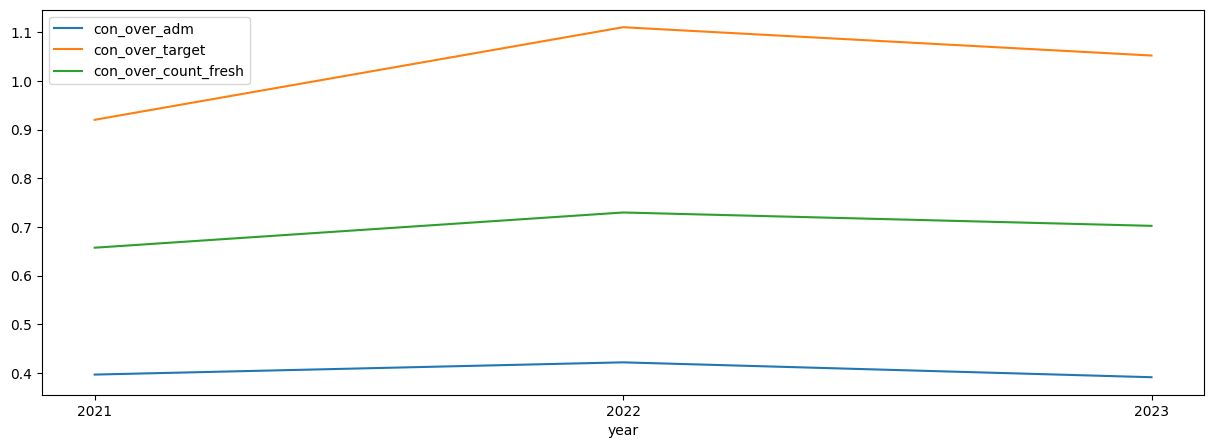

In [32]:
#| include: false

#Plot change overtime of con / adm, con / target, and con / count of freshmen in class, for ENGR 102 (view only fall values since winter is discontinued for now)
(full_df.query("Subject == 'ENGR' and Course_Number == 102.0 and is_fall == True")
 .sort_values(by='year')
 .plot(x='year', y=['con_over_adm', 'con_over_target', 'con_over_count_fresh'], figsize=(15,5))
)
plt.xticks(range(2021, 2024));

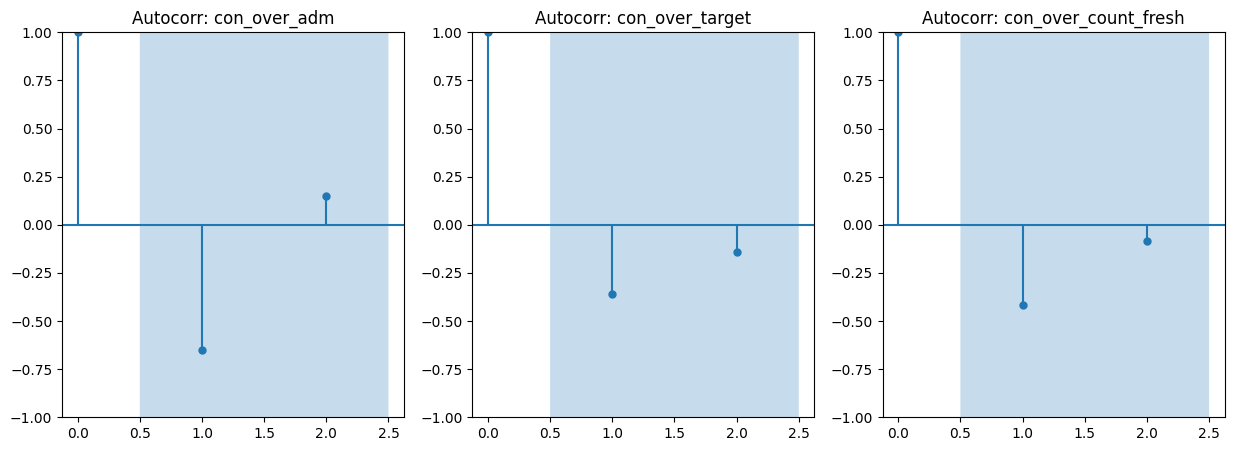

In [33]:
#| include: false

#Look at autocorrelation of these values
feat_list = ['con_over_adm', 'con_over_target', 'con_over_count_fresh']

fig, axes = plt.subplots(1, 3, figsize=(15,5))
temp_df = (full_df.query("Subject == 'ENGR' and Course_Number == 102.0 and is_fall == True")
           .sort_values(by='year'))

for i, col in enumerate(feat_list):
    plot_acf(temp_df[col], ax=axes[i], title=f"Autocorr: {col}")

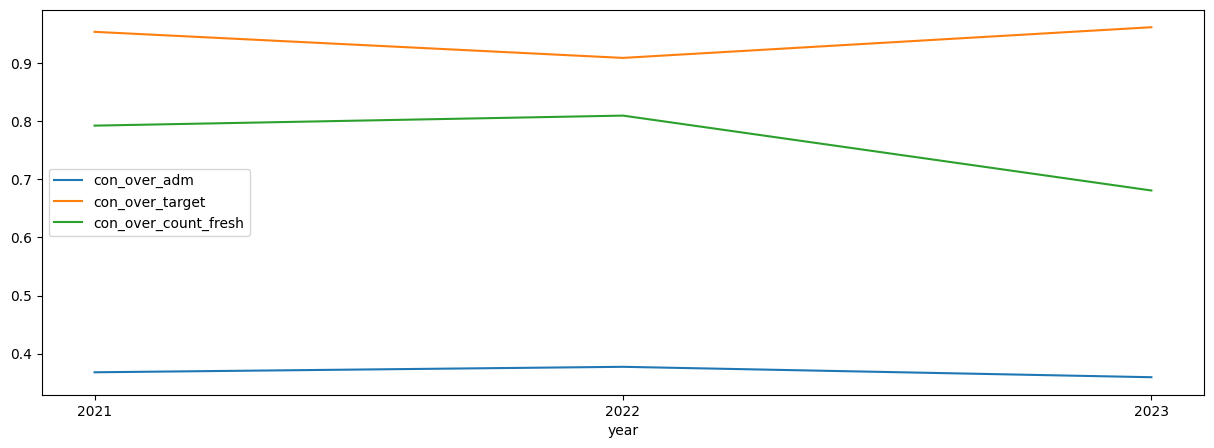

In [34]:
#| include: false

#Look at MATH 140 (also very popular freshmen course)
(full_df.query("Subject == 'MATH' and Course_Number == 140.0 and is_fall == True")
 .sort_values(by='year')
 .plot(x='year', y=['con_over_adm', 'con_over_target', 'con_over_count_fresh'], figsize=(15,5))
)
plt.xticks(range(2021, 2024));

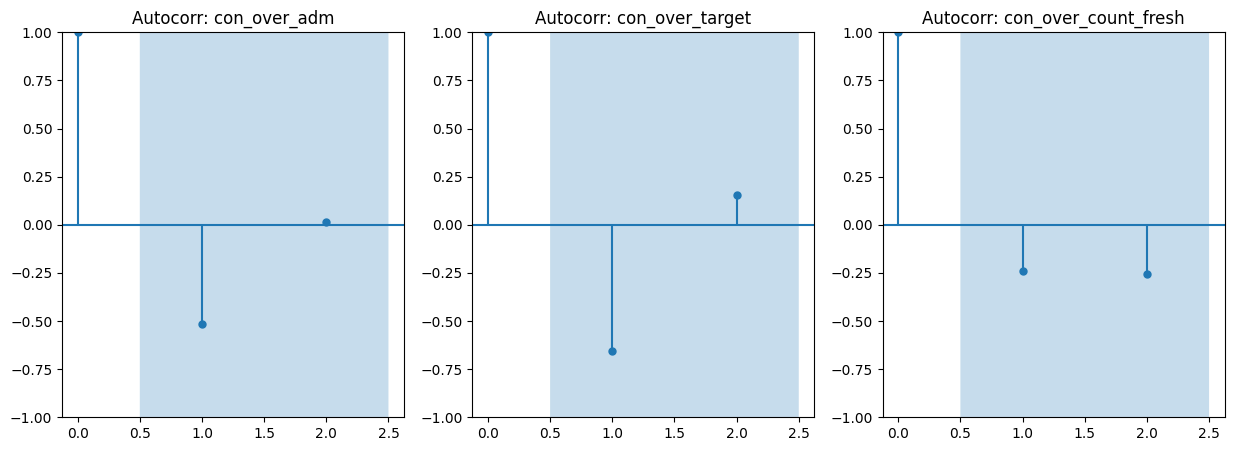

In [35]:
#| include: false

#Plot autocorrelation as well
feat_list = ['con_over_adm', 'con_over_target', 'con_over_count_fresh']

fig, axes = plt.subplots(1, 3, figsize=(15,5))
temp_df = (full_df.query("Subject == 'MATH' and Course_Number == 140.0 and is_fall == True")
           .sort_values(by='year'))

for i, col in enumerate(feat_list):
    plot_acf(temp_df[col], ax=axes[i], title=f"Autocorr: {col}")

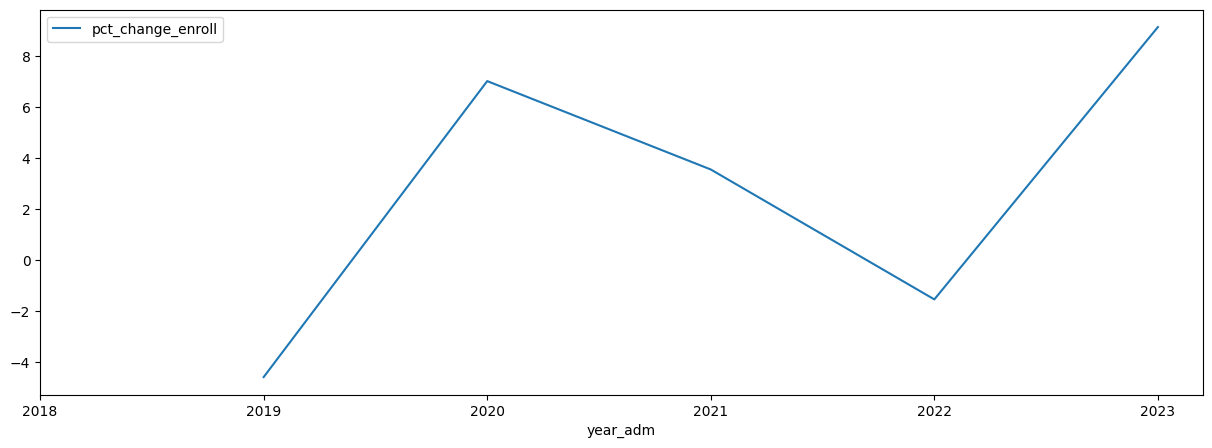

In [36]:
#| include: false

#Look at freshmen enrollment % change overtime
(result['UIN_dta'].assign(year_adm = lambda x: round(x['TERM_ADM'] * .01).apply(int))
 .query("year_adm >= 2023 - 5")
 .groupby(['year_adm'])
 .size()
 .reset_index(name='count')
 .assign(pct_change_enroll = lambda x: (x['count'] - x['count'].shift(1)) / x['count'].shift(1) * 100)
 .plot(x='year_adm', y='pct_change_enroll', figsize=(15,5)))

plt.xticks(range(2018,2024));

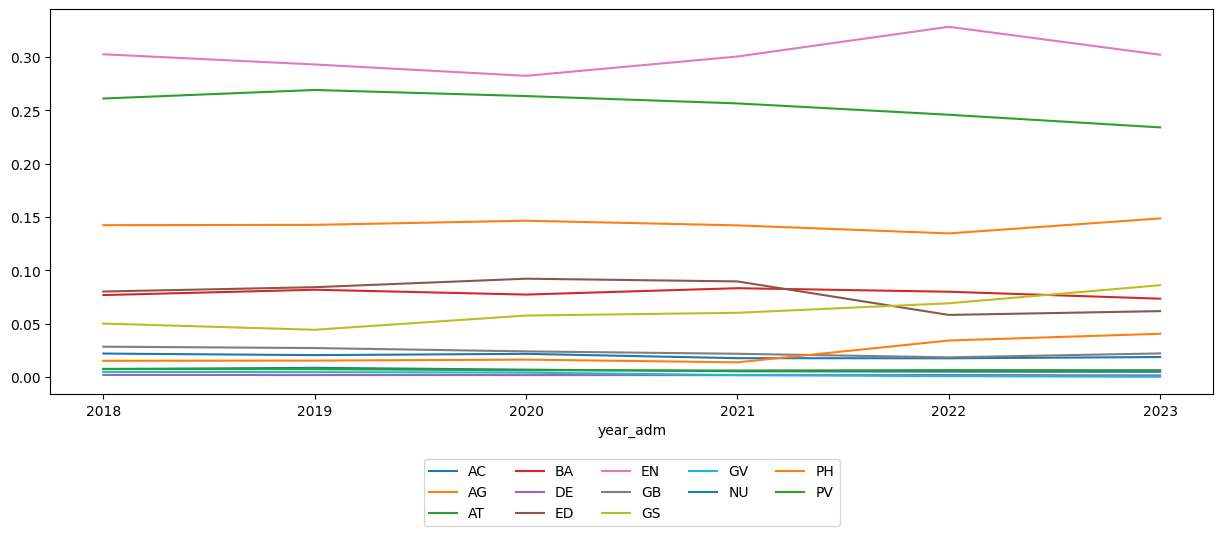

In [37]:
#| include: false

#Look at share of freshmen enrollment by year, college
(result['UIN_dta'].assign(year_adm = lambda x: round(x['TERM_ADM'] * .01).apply(int))
 .query("year_adm >= 2023 - 5")
 .groupby(['year_adm', 'COLL_ADM'])
 .size()
 .reset_index(name='count')
 .assign(yr_count = lambda x: x.groupby(['year_adm'])['count'].transform('sum'))
 .assign(pct_share = lambda x: x['count'] / x['yr_count'])
 .pivot_table(index='year_adm', columns='COLL_ADM', values='pct_share')
 .plot(figsize=(15,5))
)

plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.15));

In [38]:
#| include: false

#Add share of freshmen enrollment to full_df as well as new column of pct_class_share to calculate num freshmen in class / total freshmen enrolled that year
temp_df = (result['UIN_dta'].assign(year_adm = lambda x: round(x['TERM_ADM'] * .01).apply(int))
 .query("year_adm >= 2023 - 5")
 .groupby(['year_adm', 'COLL_ADM'])
 .size()
 .reset_index(name='count')
 .assign(yr_count = lambda x: x.groupby(['year_adm'])['count'].transform('sum'))
 .assign(pct_share = lambda x: x['count'] / x['yr_count'])
)

full_df = (full_df.merge(temp_df, how='inner', left_on=['year', 'College'], right_on=['year_adm', 'COLL_ADM'])
 .drop(columns=['COLL_ADM'], axis=1)
 .assign(pct_class_share = lambda x: x['count_freshmen'] / x['yr_count']))

# Forecasting Possibilities

As mentioned earlier in the analysis, the ultimate goal of this project is to accurately forecast to the enrollment of the next semester, down to the class level. To tackle this problem, we will first attempt to forecast for the entire university enrollment for the next term. The idea is that if we are confident in our ability to forecast for the entire university, we can continue to specify the model down to the class level. Essentially, we attempt a "simpler" forecasting problem first and will tackle the more complex one later. @fig-forecast-1 shows the total number of university enrollment over time. 

<Axes: xlabel='TERM'>

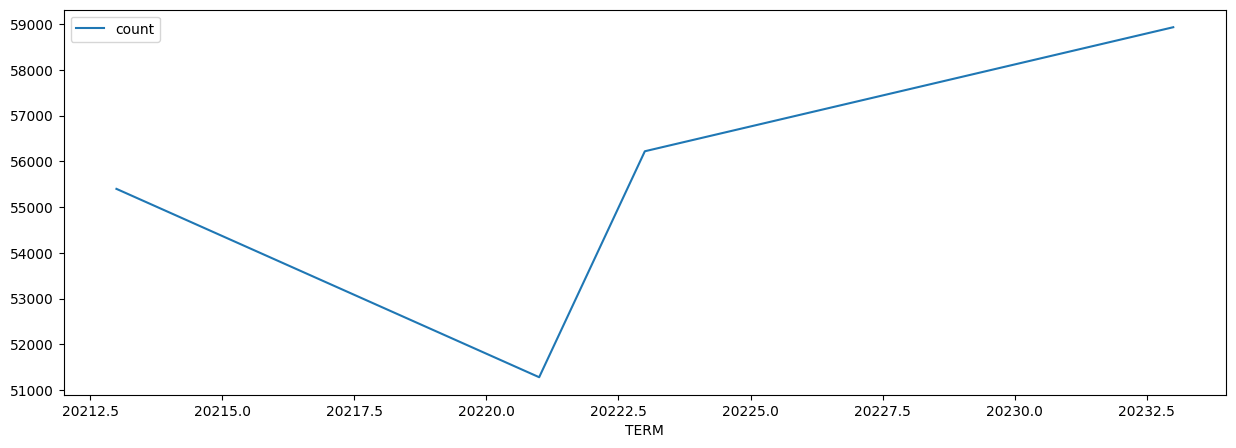

In [39]:
#| include: false

#Number of students by term (perhaps edit to get number of students per year)
(result['grades_all'].groupby(['TERM'])['UIN']
 .nunique()
 .reset_index(name='count')
 .query("TERM != 20231.0")
 .plot(x='TERM', y='count', figsize=(15,5))
)


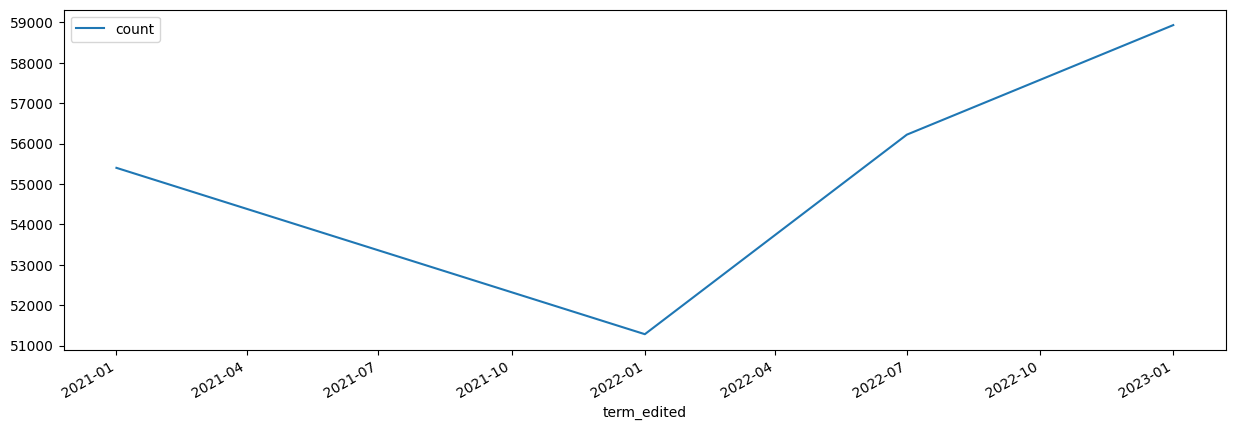

In [40]:
#| label: fig-forecast-1
#| fig-cap: "Total number of enrolled students at TAMU over time"

#Get number of students by term and reorganize term into artificial dates
(result['grades_all'].groupby(['TERM'])['UIN']
 .nunique()
 .reset_index(name='count')
 .query("TERM != 20231.0")
 .assign(term_edited = lambda x: pd.to_datetime(round(x['TERM'] * .1) , format='%Y'))
 .assign(term_edited = lambda x: np.where(x['TERM'] == 20223.0, x['term_edited'] + pd.DateOffset(months=6), x['term_edited']))
 .plot(x='term_edited', y='count', figsize=(15,5))
);

There appears to be a weird dip in the spring term of 2022 and then enrollment numbers return back to normal and then shows growth. As we can see, this forecasting problem will not be as straight forward due to the little amount of data we have (only 4 points of data). Additionally, this point at the beginning of spring 2022 seems to be an "outlier" in terms of the natural trend and growth of the university. Generally speaking, university enrollment grows (even if at a small rate) or at least remains fairly consistent (at least at large and well-known universities such as TAMU). 

In forecasting problems such as this one, it is best to use datasets that are consistent and evenly spaced. Due to the irregular nature of the decrease in spring term of 2022, we will eliminate this point from the dataset and consequently, remove other data points associated with spring term. While the act of removing data points is risky due to the value of the information, to remain consistent and to simplify our model a bit, we will proceed with only forecasting for fall term enrollment. An example dataframe with these data points are provided below. 

In [41]:
#| include: false

#Build test arima df (exclude winter semesters)
test_arima_df = (result['grades_all'].groupby(['TERM'])['UIN']
 .nunique()
 .reset_index(name='count')
 .query("TERM != [20231.0, 20221.0]")
 .assign(term_edited = pd.to_datetime(['2021-01-01', '2021-02-01', '2021-03-01'], format='%Y-%m-%d'))
)

In [42]:
#Reset index to term_edited
test_arima_df.set_index('term_edited', inplace=True)

In [43]:
test_arima_df

,TERM,count
term_edited,,
2021-01-01,20213.0,55400
2021-02-01,20223.0,56222
2021-03-01,20233.0,58933


Ignoring the term_edited column (created for ease of modeling), we see that we have 3 fall terms to use for our model. If we were to perform a train-test split on this data, this would mean that we would be left with 2 data points to train and 1 to predict. This is a fairly small training size to use and to have great confidence in what our next fall semester enrollment number would be. 

To demonstrate this, we fit an ARIMA(0,0,0) model to predict 2023 fall enrollment using 2021 and 2022 as training data. Below are the results of our model.

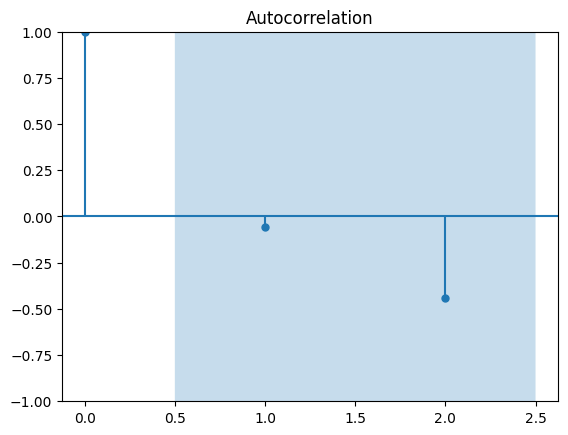

In [44]:
#| include: false

#Plot autocorrelation of enrollment
plot_acf(test_arima_df['count']);

In [45]:
#Fit ARIMA 0 0 0
train_data = test_arima_df.iloc[:2]

mod = sm.tsa.arima.ARIMA(train_data['count'], order=(0,0,0))
res = mod.fit()

/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [46]:
#Print summary
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                    2
Model:                          ARIMA   Log Likelihood                 -14.875
Date:                Fri, 31 May 2024   AIC                             33.750
Time:                        21:04:42   BIC                             31.136
Sample:                             0   HQIC                            28.284
                                  - 2                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.581e+04    291.391    191.533      0.000    5.52e+04    5.64e+04
sigma2      1.694e+05   9.06e+07      0.002      0.999   -1.77e+08    1.78e+08
Ljung-Box (L1) (Q):                   2.00   Jarque-

/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/mlemodel.py:3159: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


In [47]:
#Forecast for 2023 fall
print(f"Predicted number of students for fall 2023: {round(res.forecast(steps=1).values[0])}")
print(f"Actual number of students for fall 2023: {test_arima_df['count'].iloc[2]}")

Predicted number of students for fall 2023: 55811
Actual number of students for fall 2023: 58933


/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


The model, all things considered, performed fairly well at prediction! In the grand scheme of college enrollment, being off by approximately 3000 students is not bad. However, this model is a very simplified approach to our problem. We still need a model to predict the enrollment down to specific class level. 

In [48]:
#Create dataframe to attach enrollments counts by year and semester
enroll_df = ((result['grades_all'].groupby(['TERM'])['UIN']
 .nunique()
 .reset_index(name='count')
 .assign(is_fall = lambda x: x['TERM'])
 .assign(is_fall = lambda x: x['is_fall'].apply(str).apply(list))
 .assign(is_fall = lambda x: np.where(x['is_fall'].str[4] == '3', True, False))
 .assign(TERM = lambda x: round(x['TERM'] * .1))
 .rename(columns={'TERM':'temp_year', 'is_fall':'is_fall_2', 'count':'total_enroll'}))
)

In [49]:
#| include: false

enroll_df

,temp_year,total_enroll,is_fall_2
0,2021.0,55400,True
1,2022.0,51283,False
2,2022.0,56222,True
3,2023.0,1588,False
4,2023.0,58933,True


In [50]:
#| include: false

#Use full_df information to get average pct_of_enroll
avg_pct_enroll = (full_df.query("Subject == 'MATH' and Course_Number == 140.0")
 .merge(enroll_df[['temp_year', 'is_fall_2', 'total_enroll']], how='inner', left_on=['year', 'is_fall'], right_on=['temp_year', 'is_fall_2'])
 .drop(['is_fall_2', 'temp_year'], axis=1)
 .assign(pct_of_enroll = lambda x: x['count_students'] / x['total_enroll'])
 .query("year != 2023.0 and is_fall == True")['pct_of_enroll'].mean()
)

print(f"Average % of enroll in MATH 140 for 2021 and 2022 fall: {round(avg_pct_enroll, 3)}")

Average % of enroll in MATH 140 for 2021 and 2022 fall: 0.064


In [51]:
#| include: false

#Get actual number of students and show difference
act_num = (full_df.query("Subject == 'MATH' and Course_Number == 140.0 and is_fall == True and year == 2023.0")['count_students'].values[0])

print(f"Predicted number of students for MATH 140 for fall 2023: {round(res.forecast(steps=1).values[0] * avg_pct_enroll)}")
print(f"Actual number of students for MATH 140 for fall 2023: {act_num}")

Predicted number of students for MATH 140 for fall 2023: 3573
Actual number of students for MATH 140 for fall 2023: 4392


/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/thebscotte/miniconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


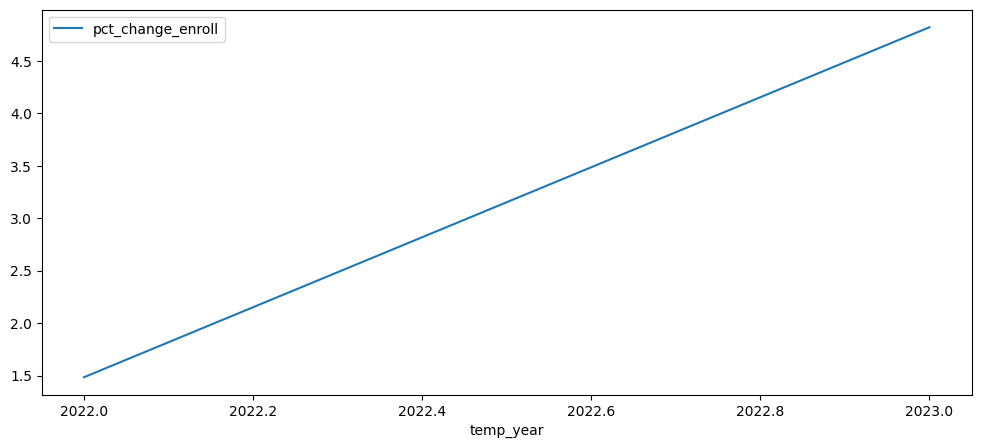

In [52]:
#| include: false

#Calculate pct change between fall semesters
(enroll_df.query("is_fall_2 == True")
 .assign(pct_change_enroll = lambda x: (x['total_enroll'] - x['total_enroll'].shift(1)) / x['total_enroll'].shift(1) * 100)
 .plot(x='temp_year', y='pct_change_enroll', figsize=(12,5)));

One possible way we can enhance our model is to go from tackling the problem head on to viewing it from a different perspective. Instead of forecasting the exact number of students on campus and then figuring out how to forecast enrollment for each class, we can predict the <b>rate of change</b> between semesters. While this approach would reduce our training data in half due to needing to calculate rate of change between semesters, this approach allows us a more flexible model because we can incorporate prior data. Essentially, this approach allows for a more natural Bayesian workflow to solving this problem. 

Below is a table that shows the percent change in enrollment between semesters. We see that from 2021-2022, TAMU saw about a 1.5% increase in enrollment and from 2022-2023, TAMU saw about a 4.8% increase in enrollment. Do we believe this trend will continue? What do we believe to be a viable estimate for percent change between semesters? Tackling this problem using Bayesian methodology allows us gather good inference and possibly have more accurate predictions by using prior information and updating it with our data. 

In [53]:
#Raw table of pct_change_enroll
(enroll_df.query("is_fall_2 == True")
 .assign(pct_change_enroll = lambda x: (x['total_enroll'] - x['total_enroll'].shift(1)) / x['total_enroll'].shift(1) * 100)
)

,temp_year,total_enroll,is_fall_2,pct_change_enroll
0,2021.0,55400,True,NaN
2,2022.0,56222,True,1.483755
4,2023.0,58933,True,4.821956


In [54]:
#| include: false

#Look at how count of students taking classes from each college change over time (note: students can take multiple classes within a college)
(full_df.groupby(['year', 'is_fall', 'College'])['count_students']
 .sum()
 .reset_index()
 .query("is_fall == True")
 .assign(pct_change_col = lambda x: x.groupby('College')['count_students'].pct_change() * 100)
 .query("College == 'EN'"))

,year,is_fall,College,count_students,pct_change_col
5,2021,True,EN,49676,NaN
25,2022,True,EN,49607,-0.138900
41,2023,True,EN,52488,5.807648


In [55]:
#Officially merge enroll_df into full_df
full_df = (full_df.merge(enroll_df[['temp_year', 'is_fall_2', 'total_enroll']], how='inner', left_on=['year', 'is_fall'], right_on=['temp_year', 'is_fall_2'])
 .drop(['is_fall_2', 'temp_year'], axis=1)
 .assign(pct_of_enroll = lambda x: x['count_students'] / x['total_enroll'])
)

# Bayesian Modeling

To continue with our analysis, we add a Bayesian twist to it by deciding on a prior belief of percent change in enrollment. For our analysis (and from a brief Google search), we say that the percent change in enrollment between semesters is likely to be normally distributed with some mean $\mu$ and some variance $\sigma^{2}$. Normally, in frequentist approaches, we would set $\mu$ and $\sigma^{2}$ by finding the MLE of each from our data and proposing that as our findings. In our Bayesian approach, we place uncertainty on these parameters by assigning each a prior distribution to express our beliefs of each parameter. For our analysis, we will assume the following distributions for $\mu$ and $\sigma^{2}$.

$$
\mu \sim N(0.03, 0.02)
$$

$$
\sigma \sim HN(0.02)
$$

We propose that $\mu$ is normally distributed with mean = 0.03 and sd = 0.02 with our $\sigma$ being distributed in a half-normal distribution with parameter 0.02. With these priors, we believe that on average, the percent change in enrollment increases about 3% YoY. However, to express our uncertainty about this value, we use a wider sd of 0.02. Utilizing priors allow us to incorporate more data into our model while also allowing the model to vary due to our uncertainty of our prior beliefs. 

Now that we have set our priors, we setup our Bayesian model using <a href="https://num.pyro.ai/en/stable/getting_started.html">numpyro</a> to perform our analysis. We use a NUTS sampler with 100 burn-in samples and 3000 MC samples. Below are the results of our sampling.

## Model 1: Overall pct_change in Enrollment

In [56]:
#Set up basic bayesian model
def model(pct_change):
    
    #Prior for pct_change_enroll
    mu = numpyro.sample("mu", dist.Normal(0.03, 0.02))
    
    #Prior for variance
    sigma = numpyro.sample("sigma", dist.HalfNormal(0.02))
    
    #Likelihood
    numpyro.sample("obs_change", dist.Normal(mu, sigma), obs=pct_change)

In [57]:
#Perform bayesian
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=3000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, np.array([.0148]))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
sample: 100%|██████████████████████████| 3100/3100 [00:01<00:00, 1674.31it/s, 13 steps of size 2.42e-01. acc. prob=0.92]


In [58]:
#Print summary
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      0.02      0.01      0.02      0.00      0.04    682.95      1.00
     sigma      0.01      0.01      0.01      0.00      0.03    596.88      1.00

Number of divergences: 62


Training our model on just the percent change between 2021-2022 fall terms, we see our model has shifted the mean of our parameter $\mu$ from 0.03 to 0.02. Additionally, our sd shrunk as well from 0.02 to 0.01. Our r_hat values of 1.00 and high n_eff scores are good indicators that our model achieved stationarity and good mixing. To continue to confirm that our model has good MCMC diagnostics, we view the trace plots for each of our parameters of interest (see @fig-trace-1).

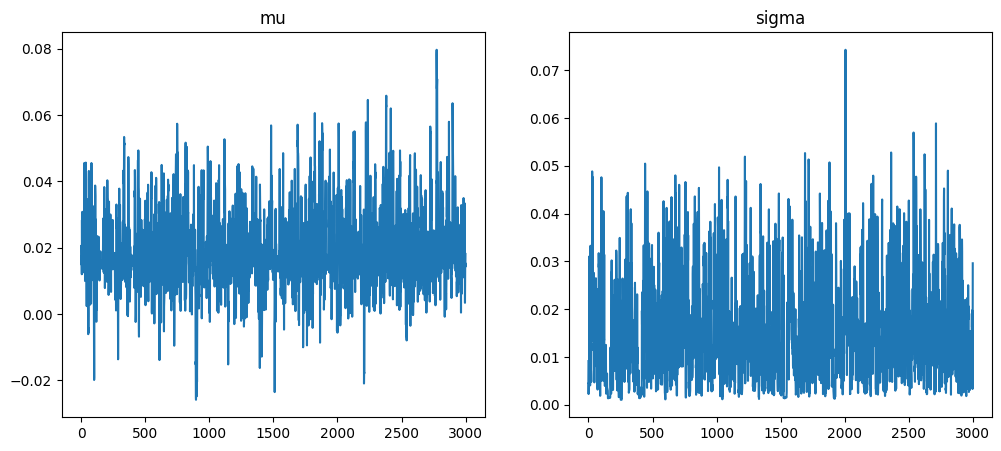

In [59]:
#| label: fig-trace-1
#| fig-cap: "Trace plots for mu and sigma"

#Plot chains for diagnostics
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(mcmc.get_samples()['mu'])
ax[0].set_title("mu")
ax[1].plot(mcmc.get_samples()['sigma'])
ax[1].set_title("sigma");

@fig-trace-1 shows that our sampler mixed well and converged well, as both plots don't appear to get stuck in any one particular region for too long.

@fig-post-1 below shows how our prior has been updated using the MAP estimates from our sampler. We see visually what we noticed in the table above, that our posterior became more peaked and shifted left about the x axis. 

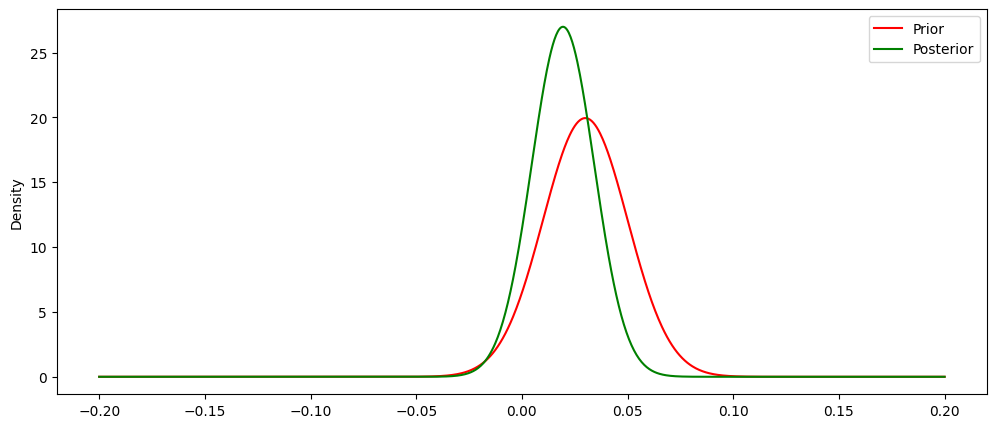

In [60]:
#| label: fig-post-1
#| fig-cap: "Prior and posterior distributions based on MAP values"

#Plot prior and posterior
post_samples = mcmc.get_samples()
x = np.linspace(-0.2, 0.2, 1000)
prior_density_log = dist.Normal(0.03, 0.02).log_prob(x)
post_density_log = dist.Normal(post_samples['mu'].mean(), post_samples['sigma'].mean()).log_prob(x)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x, np.exp(prior_density_log), label='Prior', color='red')
ax.plot(x, np.exp(post_density_log), label='Posterior', color='green')
ax.set_ylabel("Density")
ax.legend();

In [61]:
#| include: false

#Show mean and sd of posterior (based on average of samples)
print(f"Average Posterior mu: {post_samples['mu'].mean()}")
print(f"Average Posterior sigma: {post_samples['sigma'].mean()}")

Average Posterior mu: 0.019428273662924767
Average Posterior sigma: 0.01478323619812727


While @fig-post-1 is informative in showing how the MAP values update our prior, the power of Bayesian analysis comes from viewing the entire distribution of each parameter of interest and subsequently using those distributions to provide a predictive distribution, or posterior predictive distribution from which we can gather inference and make forecasts. Below in @fig-post-2 we see the complete distributions for each parameter of interest.

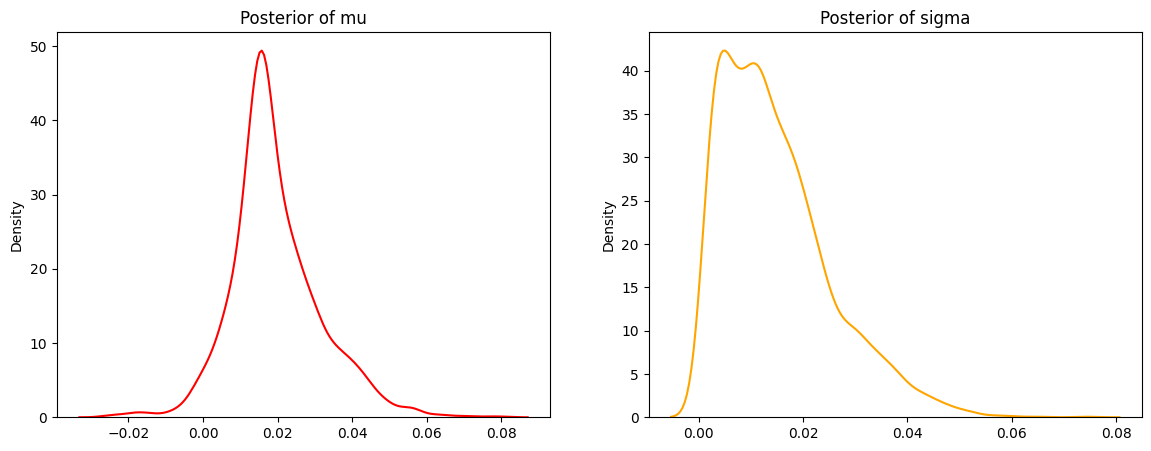

In [62]:
#| label: fig-post-2
#| fig-cap: "Posterior distributions of mu and sigma"

#Show posterior distributions for mu and sigma

fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.kdeplot(post_samples['mu'], ax=ax[0], color='red')
sns.kdeplot(post_samples['sigma'], ax=ax[1], color='orange')

ax[0].set_title("Posterior of mu")
ax[1].set_title("Posterior of sigma");

@fig-post-2 shows that our mu distribution still appears to be approximately normal, centered around 0.02. Our posterior of sigma is less peaked (almost bimodal) but is generally centered around 0.01. Our mu distribution shows that while it is most likely that we have an increase of student enrollment around 2% for this upcoming year, it is within reasonable probability that we could see no increase (eg 0% change). We can use 95% credible intervals to demonstrate what plausible values are  within 95% probability for each parameter or interest.

In [63]:
#Show 95% CI for mu
print(f"95% CI for mu: ({np.quantile(post_samples['mu'], 0.025)}, {np.quantile(post_samples['mu'], 0.975)})")

95% CI for mu: (-0.001442579022841527, 0.046437517087906624)


In [64]:
#Show 95% CI for sigma
print(f"95% CI for sigma: ({np.quantile(post_samples['sigma'], 0.025)}, {np.quantile(post_samples['sigma'], 0.975)})")

95% CI for sigma: (0.0015739109367132187, 0.04049663208425045)


Our 95% CI for mu shows that within our 95% probability range, we could possibly see a decrease in student enrollment (be it a small one), but that the majority of our 95% CI includes positive values, meaning we would more than likely see some kind of increase for the next fall term. 

Text(0, 0.5, 'sigma')

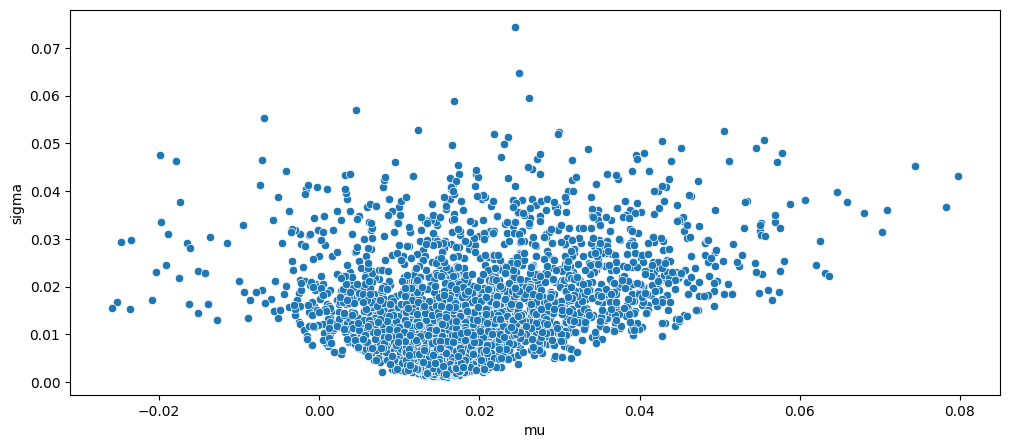

In [65]:
#| include: false

#Show joint distribution
fig, ax = plt.subplots(figsize=(12,5))

sns.scatterplot(x=post_samples['mu'], y=post_samples['sigma'], ax=ax)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')

## Posterior Predictive Distribution (% Change in Enrollment)

As mentioned previously, we can now make predictions utilizing our posterior distributions. This is done by integrating out all of our parameters of interest (see @eq-pred-1).

$$
p(\overset{\sim}{y}|y_{1}...y_{n}) = \int_{\Theta} p(\overset{\sim}{y}|\theta)p(\theta|y)
$${#eq-pred-1}

What @eq-pred-1 says is that in order for us to derive the posterior predictive distribution, integrate across all possible parameters of interest (in our case, mu and sigma) to derive a single distribution, conditioned upon our observed data. Our resulting posterior predictive distribution is found in @fig-post-pred-1.

In [66]:
#Derive PPD from Bayesian model
ppd_enroll = Predictive(model, post_samples)

In [67]:
#Generate synthetic data for PPD
np.random.seed(121)
pct_change_syn = np.random.normal(post_samples['mu'], post_samples['sigma'])

In [68]:
#Generate PPD using synthetic data
post_pred_samples = ppd_enroll(rng_key, pct_change_syn)

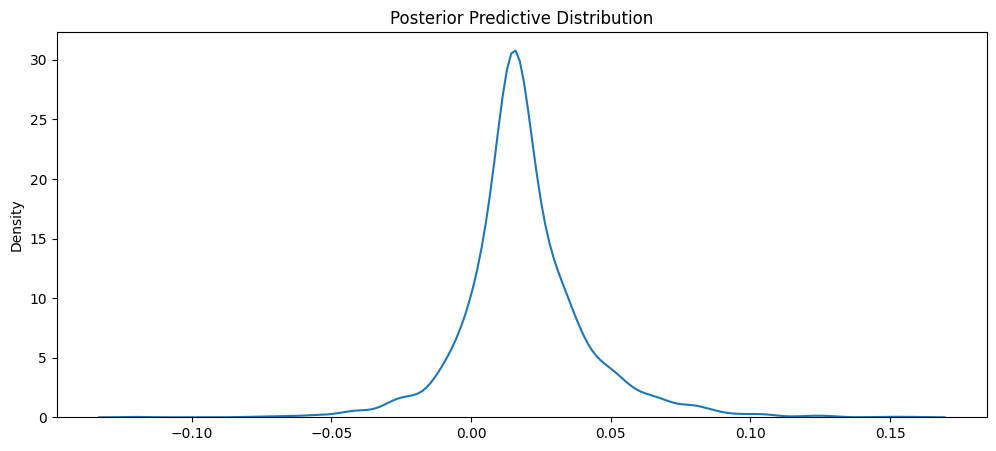

In [69]:
#| label: fig-post-pred-1
#| fig-cap: "Posterior predictive distribution for predicting percent change in enrollment"

#Plot PPD
plt.figure(figsize=(12,5))
sns.kdeplot(post_pred_samples['obs_change'][0,:])
plt.title("Posterior Predictive Distribution");

In [70]:
#Calculate mean
print(f"Mean of PPD: {post_pred_samples['obs_change'][0,:].mean()}")

Mean of PPD: 0.019076179713010788


In [71]:
#Print 95% CI
print(f"95% CI of PPD: ({np.quantile(post_pred_samples['obs_change'][0,:], .025)} , {np.quantile(post_pred_samples['obs_change'][0,:], .975)})")

95% CI of PPD: (-0.023650801740586758 , 0.07064365874975921)


Our posterior predictive distribution is centered around 2% still but appears to be a wider distribution. This is because of our wider interval with our sigma distribution. Nonetheless, it is still an approximately normal distribution centered around 2% with corresponding 95% CI (or PI in this case) stating that with 95% probability the percent change in enrollment for the upcoming fall term will be between -2% and 7%. While this interval may be wider than desired, for utilizing only one training point of data and our weakly informative prior, it is a sufficient resource in predicting our fall enrollment for TAMU.  

To make specific predictions using this distribution, we can utilize the MAP for a point estimate and the 95% CI for a range of predictions. Those results are shown below. 

In [72]:
#Make predictions based on average from posterior
bayes_pred = (round(post_pred_samples['obs_change'][0,:].mean(), 2) + 1) * enroll_df.query("temp_year == 2022 and is_fall_2 == True")['total_enroll'].values[0]
true_pred = enroll_df.query("temp_year == 2023 and is_fall_2 == True")['total_enroll'].values[0]
print(f"Bayesian Prediction of Enrollment: {round(bayes_pred)}")
print(f"Actual Enrollment: {true_pred}")

Bayesian Prediction of Enrollment: 57346
Actual Enrollment: 58933


In [73]:
#Get 95% PI for enrollment
ly_val = enroll_df.query("temp_year == 2022 and is_fall_2 == True")['total_enroll'].values[0]
lwr = np.quantile(post_pred_samples['obs_change'][0,:], .025)
upr = np.quantile(post_pred_samples['obs_change'][0,:], .975)
print(f"95% Prediction Interval for Enrollment: ({ly_val * (round(lwr, 2) + 1):.0f}, {ly_val * (round(upr, 2) + 1):.0f})")

95% Prediction Interval for Enrollment: (55098, 60158)


As we can see, our Bayesian prediction performed much better than our ARIMA model (granted it was a (0,0,0) model). Additionally, our 95% PI captures the actual value for fall 2023 enrollment at TAMU. As our model continues to receive more data, it will be able to shrink its PI range and have more precise predictions for our forecasts. Nonetheless, we have a viable first model at predicting enrollment at TAMU. 

In [74]:
#| include: false

#Get prediction for MATH 140
avg_pct_enroll = full_df.query("Subject == 'MATH' and is_fall == True and Course_Number == 140.0 and year < 2023.0")['pct_of_enroll'].mean()
true_math = full_df.query("Subject == 'MATH' and is_fall == True and Course_Number == 140.0 and year == 2023.0")['count_students'].values[0]
print(f"Bayesian Prediction of # Students in MATH 140: {round(bayes_pred * avg_pct_enroll)}")
print(f"Actual # of Students in MATH 140: {true_math}")

Bayesian Prediction of # Students in MATH 140: 3672
Actual # of Students in MATH 140: 4392


In [75]:
#| include: false

#Calculate probability that pct_change in enrollment for fall 2023 is > .02
(post_pred_samples['obs_change'][0,:] > .02).mean().tolist()

0.3943333327770233

## More exploration (For enhanced Bayesian Modeling)

While the above model successfully performed better than our "frequentist" approach, it still has not accomplished our ultimate goal of forecasting down to the classroom level. How can we utilize our first model as a viable resource to build a second model that can forecast down to the classroom level?  

The question to explore now is "do we believe that the percent share of enrollment by class varies or is relatively constant?". Essentially, if we discover that classes are generally consistent in how much percent of enrollment they take each fall term, then we can build a model that forecasts from our first model and utilizes class specific information to predict its percent share of enrollment. For example, suppose we have an intro level math class that for 3 fall terms had percent share of enrollment of: 2%, 3%, 4%. Utilizing our first model that predicts the entire university enrollment, we can generate a posterior predictive distribution that can predict the percent change in percent share of enrollment and multiply that change in value by the first predicted value (total university enrollment) to get a class specific enrollment value. @eq-mod-1 shows the more pretty math behind this intuition.

$$
\text{class level enrollment} = (\text{LY } \% \text{ enrollment} * (1 + \% \text{ change in enrollment})) * (\text{forecasted enrollment})
$${#eq-mod-1}

Below is an example table of the data we will utilize to forecast percent share of total enrollment by class. 

In [76]:
#Look at engineering college by subject, course number and see if there is any trend
(full_df.query("Course_Number >= 100.0 and Course_Number < 200.0")
 .query("College == 'EN' and is_fall == True")[['Subject', 'Course_Number', 'is_fall', 'year', 'count_students', 'pct_of_enroll']]
 .sort_values(by=["Subject", "Course_Number", "year", "pct_of_enroll"])
 .head())

,Subject,Course_Number,is_fall,year,count_students,pct_of_enroll
815,AERS,101.0,True,2021,250,0.004513
5784,AERS,101.0,True,2022,293,0.005211
8394,AERS,101.0,True,2023,339,0.005752
821,AERS,105.0,True,2021,607,0.010957
5790,AERS,105.0,True,2022,589,0.010476


We can build out our formula from @eq-mod-1 by creating a new column in our full dataframe to calculate the percent change in percent share of enrollment. Below is an example of this using an intro math class (MATH 140) at TAMU (see last column).

In [77]:
#| include: false

#Find value counts of each subject course number combo
(full_df.query("is_fall == True")
 .groupby(['College', 'Subject', 'Course_Number'])
 .size())

College  Subject  Course_Number
AC       ARCH     105.0            1
                  115.0            1
                  205.0            3
                  212.0            3
                  213.0            1
                                  ..
PV       VIST     491.0            3
                  494.0            3
         VIZA     689.0            1
         VLCS     485.0            3
         VSCS     485.0            2
Length: 3200, dtype: int64

In [78]:
#Find pct_change for pct_of_enroll
(full_df.query("is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())
 .query("Subject == 'MATH' and Course_Number == 140.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,...,con_over_target,con_over_count_fresh,year_adm,count,yr_count,pct_share,pct_class_share,total_enroll,pct_of_enroll,pct_enroll_yoy
107,AT,MATH,140.0,True,3594,3190,294,72,38,2650,...,0.953962,0.792476,2021,4158,16207,0.256556,0.196829,55400,0.064874,NaN
5049,AT,MATH,140.0,True,3552,2975,412,114,51,2650,...,0.909057,0.809748,2022,3924,15956,0.245926,0.186450,56222,0.063178,-0.026136
7656,AT,MATH,140.0,True,4392,3744,456,139,53,2650,...,0.961887,0.680823,2023,4076,17415,0.234051,0.214987,58933,0.074525,0.179606


And another example of an intro aerospace course (AERS 101).

In [79]:
#Another example of pct_change
(full_df.query("is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())
 .query("College == 'EN'")
 .query("Subject == 'AERS' and Course_Number == 101.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,...,con_over_target,con_over_count_fresh,year_adm,count,yr_count,pct_share,pct_class_share,total_enroll,pct_of_enroll,pct_enroll_yoy
815,EN,AERS,101.0,True,250,243,5,1,1,3250,...,0.920000,12.304527,2021,4871,16207,0.300549,0.014994,55400,0.004513,NaN
5784,EN,AERS,101.0,True,293,286,7,0,0,3250,...,1.110154,12.615385,2022,5240,15956,0.328403,0.017924,56222,0.005211,0.154865
8394,EN,AERS,101.0,True,339,329,9,0,1,3250,...,1.052000,10.392097,2023,5263,17415,0.302211,0.018892,58933,0.005752,0.103773


Another thing we notice about these classes is an obvious one: they're different sizes! However, we know that they aren't all unique in their own size. We can bucket these classes into arbitrary sizes (small, medium, large, etc.) to aid our model in identifying more specifically how certain class sizes vary on their percent change in percent share of enrollment. Below in @fig-hist-1 shows a distribution of count of students for classes.

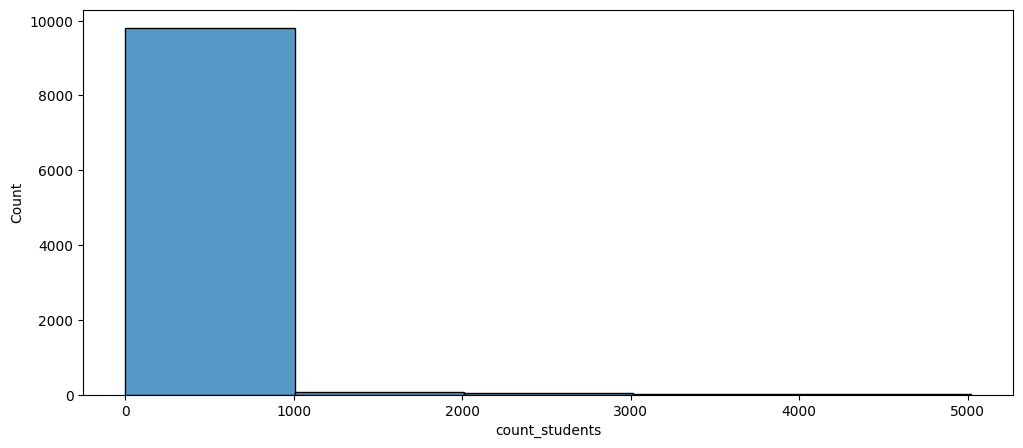

In [80]:
#| label: fig-hist-1
#| fig-cap: "Histogram of count of students in classes"

#Plot distribution of count_students and see if there are proper buckets we can use for priors
plt.figure(figsize=(12,5))
sns.histplot(x='count_students', data=full_df, bins=5);

As we can see, the great majority of class sizes are found below 1000 students.  We will need to take this into account when deciding how to divide our class size lines. While there are different ways of performing this in a more analytical way (i.e. segmentation analysis), we will arbitrarily decide on these buckets based on our EDA (see github repo for full EDA code).

In [81]:
#| include: false

#Get number of size of classes by creating column and doing value_counts
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 1000, "small", 
                                                np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "medium", 
                                                        np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "large", 
                                                                np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "x-large", "giant")))))
 .query("is_fall == True")
 ['class_size']
 .value_counts())

class_size
small      7260
medium       47
large        26
giant        10
x-large       8
Name: count, dtype: int64

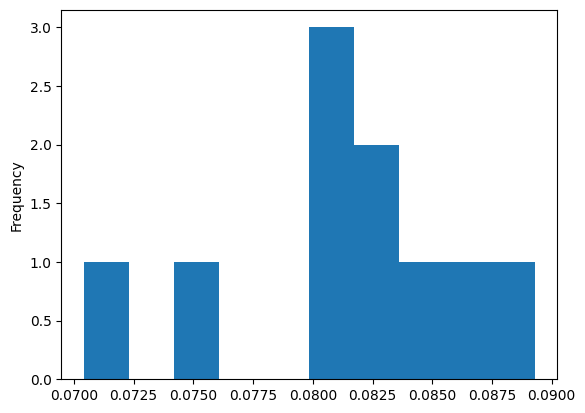

In [82]:
#| include: false

#Look at distribution of giant classes for pct_of_enroll (for fall semester only)
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 1000, "small", 
                                                np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "medium", 
                                                        np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "large", 
                                                                np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "x-large", "giant")))))
 .query("class_size == 'giant' and is_fall == True")['pct_of_enroll']
 .plot(kind='hist', x='pct_of_enroll', bins=10));

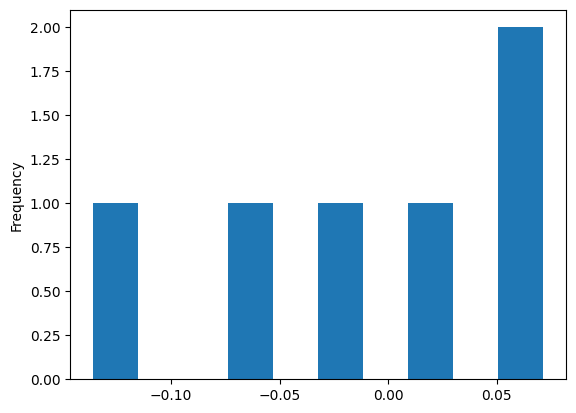

In [83]:
#| include: false

#Look at distribution of giant classes for pct_enroll_yoy
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 1000, "small", 
                                                np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "medium", 
                                                        np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "large", 
                                                                np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "x-large", "giant")))))
 .query("class_size == 'giant' and is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())['pct_enroll_yoy']
 .plot(kind='hist'));

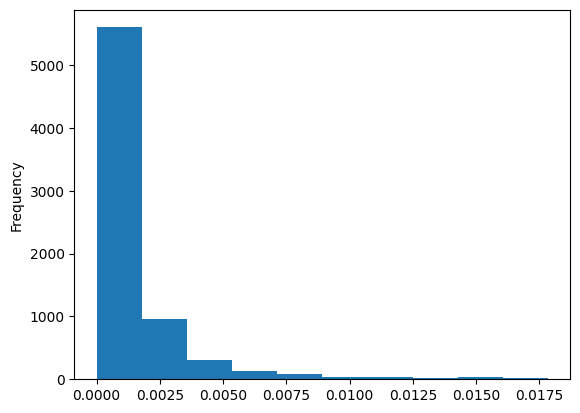

In [84]:
#| include: false

#Look at distribution of small classes for pct_of_enroll (for fall semester only)
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 1000, "small", 
                                                np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "medium", 
                                                        np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "large", 
                                                                np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "x-large", "giant")))))
 .query("class_size == 'small' and is_fall == True")['pct_of_enroll']
 .plot(kind='hist', x='pct_of_enroll', bins=10));

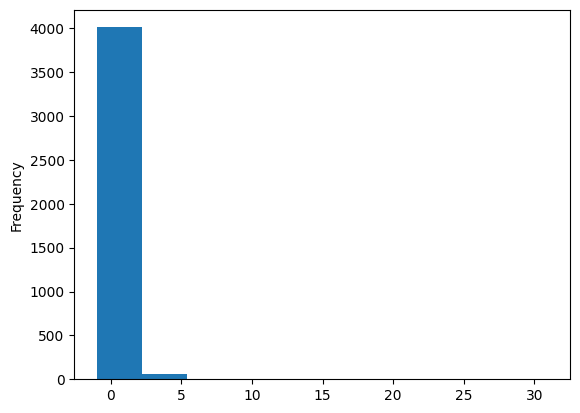

In [85]:
#| include: false

#Look at distribution of small classes for pct_enroll_yoy
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 1000, "small", 
                                                np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "medium", 
                                                        np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "large", 
                                                                np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "x-large", "giant")))))
 .query("class_size == 'small' and is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())['pct_enroll_yoy']
 .plot(kind='hist'));

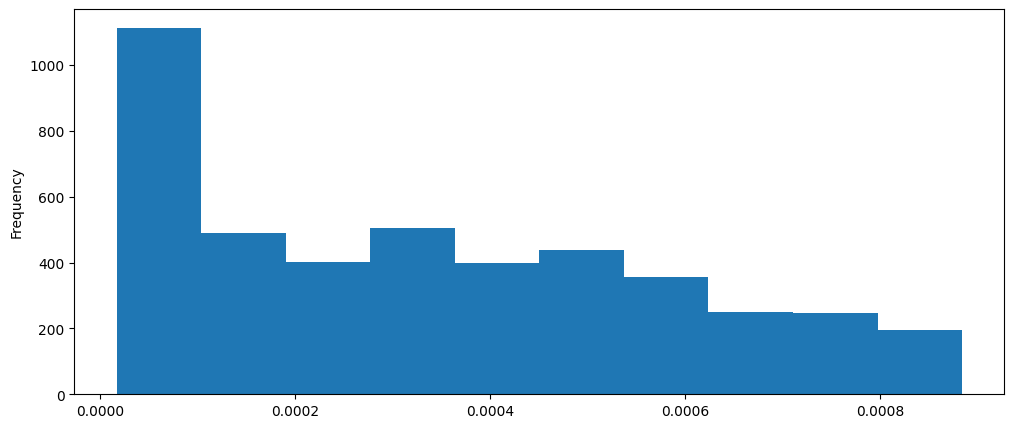

In [86]:
#| include: false

#Change bucket sizes and view x-small
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("class_size == 'x-small' and is_fall == True")['pct_of_enroll']
 .plot(kind='hist', x='pct_of_enroll', figsize=(12,5)));

In [87]:
#| include: false

#Look at bucket counts
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 ['class_size']
 .value_counts()
)

class_size
x-small      6003
medium       1713
small        1580
large         508
x-large        62
xx-large       30
giant          11
xxx-large      10
Name: count, dtype: int64

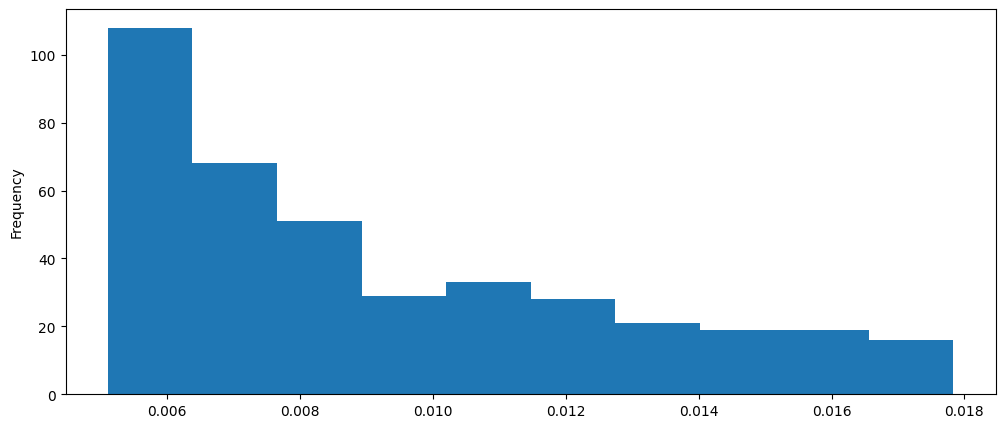

In [88]:
#| include: false

#Change bucket sizes and view large
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("class_size == 'large' and is_fall == True")['pct_of_enroll']
 .plot(kind='hist', x='pct_of_enroll', figsize=(12,5)));

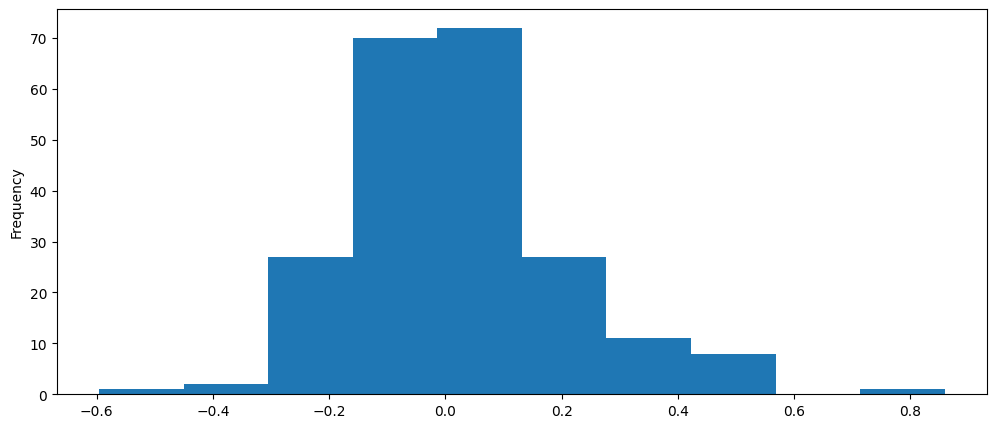

In [89]:
#| include: false

#View pct_enroll_yoy distribution for large
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("class_size == 'large' and is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())['pct_enroll_yoy']
 .plot(kind='hist', figsize=(12,5)));

In [90]:
#| include: false

#Calculate range for each group (pct_of_enroll)
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("is_fall == True")
 .groupby(['class_size'])
 .apply(lambda x: x['pct_of_enroll'].max() - x['pct_of_enroll'].min()))

class_size
giant        0.018870
large        0.012726
medium       0.003683
small        0.000939
x-large      0.018363
x-small      0.000868
xx-large     0.016984
xxx-large    0.008265
dtype: float64

One plot that we will include in this post is found in @fig-dist-1. This figure shows the distribution for percent change in percent share of enrollment for each of our arbitrarily selected class sizes. 

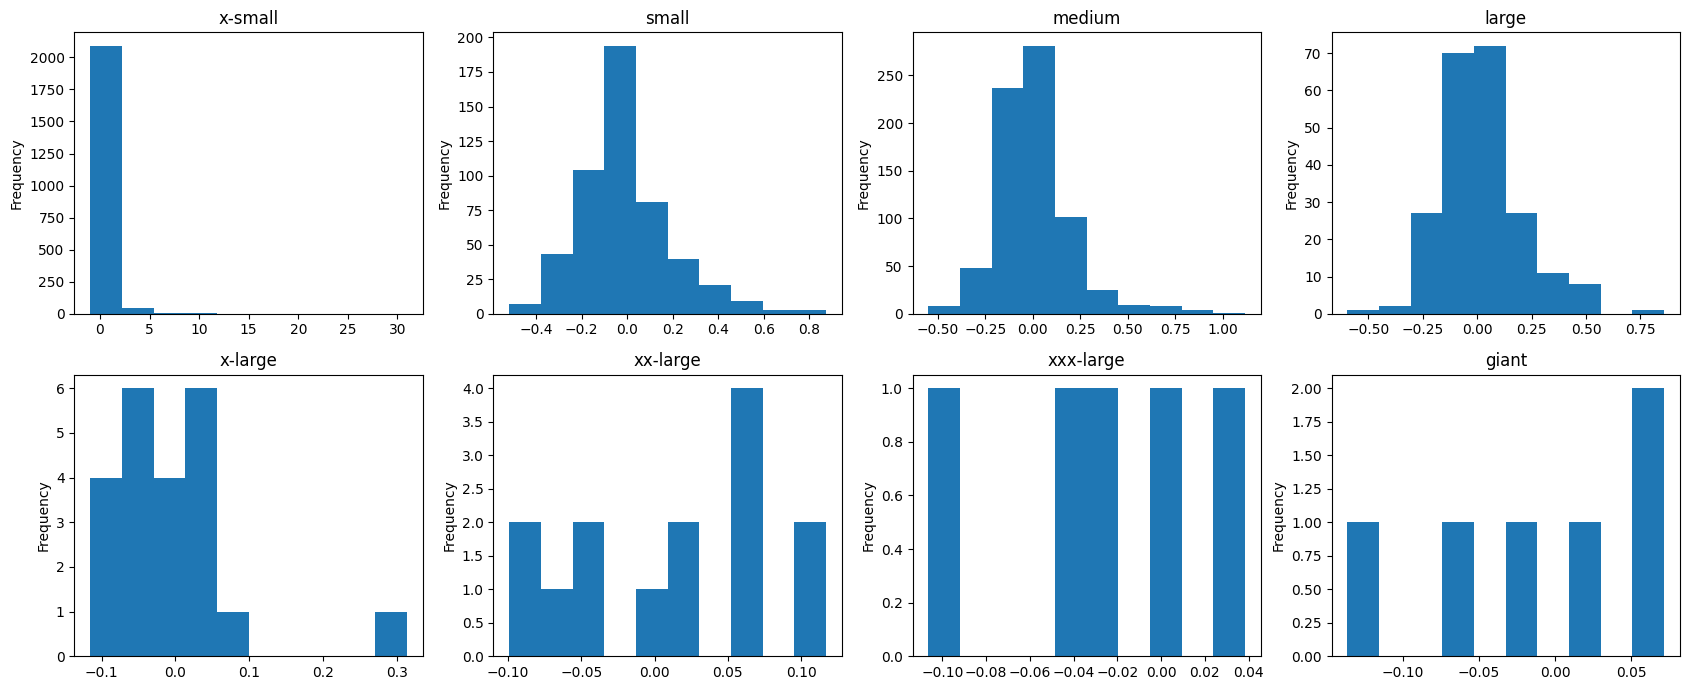

In [91]:
#| label: fig-dist-1
#| fig-cap: "2x4 grid of histograms showing the distribution of percent change in percent share of enrollment for each class size"

#Look at distribution for pct_enroll_yoy for each group
fig, ax = plt.subplots(2,4, figsize=(17,7))
groups = ['x-small', 'small', 'medium', 'large', 'x-large', 'xx-large', 'xxx-large', 'giant']

for i, a in enumerate(ax.flatten()):
    (full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query(f"class_size == @groups{[i]} and is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())['pct_enroll_yoy']
 .plot(kind='hist', ax=a, title=f"{groups[i]}"))
    

fig.tight_layout()

@fig-dist-1 is telling in many ways. First, x-small classes are generally non-variable with a few large outliers (this also is acceptable because a x-small class can double in size fairly easily). Small, medium, and large classes are approximately normal in their distribution because these are the class sizes with the most observations (kind of like a fun way of seeing the CLT). All other larger classes appear almost uniform in their distributions due to their small respective sample sizes. 

In [92]:
#| include: false

#Look at why x-small is so right skewed
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("class_size == 'x-small' and is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())
 .sort_values(by=['pct_enroll_yoy'], ascending=False)
 .head(10)
)

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,...,con_over_count_fresh,year_adm,count,yr_count,pct_share,pct_class_share,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
7841,AT,CHEM,289.0,True,34,0,2,26,6,2650,...,0.000000,2023,4076,17415,0.234051,0.000000,58933,0.000577,x-small,30.961719
9360,AG,RPTS,485.0,True,30,1,3,7,19,1400,...,0.000000,2023,2589,17415,0.148665,0.000057,58933,0.000509,x-small,27.619958
9806,GB,PSAA,601.0,True,13,0,0,5,8,250,...,0.000000,2023,384,17415,0.022050,0.000000,58933,0.000221,x-small,11.401982
9813,GB,PSAA,621.0,True,13,0,0,5,8,250,...,0.000000,2023,384,17415,0.022050,0.000000,58933,0.000221,x-small,11.401982
6166,EN,CVEN,449.0,True,10,0,1,1,8,3250,...,0.000000,2022,5240,15956,0.328403,0.000000,56222,0.000178,x-small,8.853794
8930,EN,ISTM,601.0,True,10,0,1,2,7,3250,...,0.000000,2023,5263,17415,0.302211,0.000000,58933,0.000170,x-small,8.539986
5666,AT,ANTH,485.0,True,28,5,6,7,10,2650,...,0.000000,2022,3924,15956,0.245926,0.000313,56222,0.000498,x-small,8.196874
7807,AT,JOUR,250.0,True,18,13,1,3,1,2650,...,196.076923,2023,4076,17415,0.234051,0.000746,58933,0.000305,x-small,7.585987
6822,BA,FINC,423.0,True,39,0,1,1,37,1335,...,0.000000,2022,1275,15956,0.079907,0.000000,56222,0.000694,x-small,6.685959
9494,AC,CARC,485.0,True,8,0,1,4,3,300,...,0.000000,2023,325,17415,0.018662,0.000000,58933,0.000136,x-small,6.631989


In [93]:
#| include: false

#Look at CHEM 289 data
(full_df.query("Subject == 'CHEM' and Course_Number == 289.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,...,con_over_adm,con_over_target,con_over_count_fresh,year_adm,count,yr_count,pct_share,pct_class_share,total_enroll,pct_of_enroll
287,AT,CHEM,289.0,True,1,1,0,0,0,2650,...,0.367870,0.953962,2528.0,2021,4158,16207,0.256556,0.000062,55400,0.000018
7841,AT,CHEM,289.0,True,34,0,2,26,6,2650,...,0.359368,0.961887,0.0,2023,4076,17415,0.234051,0.000000,58933,0.000577


In [94]:
#| include: false

#Look at Chem 289 data from grades
(result['grades_all'].query("Subject == 'CHEM' and Course_Number == 289.0"))

,UIN,Subject,Course_Number,Quality_Points,Course_Credits,Final_Grade,Course_Section,Status,TERM
25757,5379,CHEM,289.0,3.0,1.0,B,515,RE,20213.0
780671,3456,CHEM,289.0,0.0,1.0,IP,504,RW,20233.0
783208,4055,CHEM,289.0,0.0,0.0,IP,503,RW,20233.0
785911,4751,CHEM,289.0,0.0,1.0,IP,502,RW,20233.0
788508,5306,CHEM,289.0,0.0,1.0,IP,502,RW,20233.0
789052,5412,CHEM,289.0,0.0,1.0,IP,502,RW,20233.0
796217,57563,CHEM,289.0,0.0,1.0,IP,504,RW,20233.0
800486,58408,CHEM,289.0,0.0,0.0,IP,501,RE,20233.0
815669,10348,CHEM,289.0,0.0,0.0,IP,503,RE,20233.0
819403,11273,CHEM,289.0,0.0,1.0,IP,502,RW,20233.0


In [95]:
#| include: false

#Get values that are greater than 1 for pct_enroll_yoy
(full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("class_size == 'x-small' and is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())
 .query("pct_enroll_yoy > 1")
)

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,...,con_over_count_fresh,year_adm,count,yr_count,pct_share,pct_class_share,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
6999,AC,CARC,484.0,True,25,1,1,9,14,300,...,0.0,2022,279,15956,0.017486,0.000063,56222,0.000445,x-small,3.105747
6951,AC,COSC,322.0,True,41,3,18,12,8,300,...,0.0,2022,279,15956,0.017486,0.000188,56222,0.000729,x-small,1.126345
6987,AC,COSC,459.0,True,36,0,10,12,14,300,...,0.0,2022,279,15956,0.017486,0.000000,56222,0.000640,x-small,1.956138
6980,AC,URPN,440.0,True,10,1,3,2,4,300,...,0.0,2022,279,15956,0.017486,0.000063,56222,0.000178,x-small,1.463448
6720,AG,AGEC,491.0,True,10,0,3,5,2,1400,...,0.0,2022,2148,15956,0.134620,0.000000,56222,0.000178,x-small,2.284598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9813,GB,PSAA,621.0,True,13,0,0,5,8,250,...,0.0,2023,384,17415,0.022050,0.000000,58933,0.000221,x-small,11.401982
9819,GB,PSAA,643.0,True,21,1,0,6,14,250,...,0.0,2023,384,17415,0.022050,0.000057,58933,0.000356,x-small,3.006794
9879,PH,PHLT,491.0,True,28,3,2,12,11,450,...,0.0,2023,705,17415,0.040482,0.000172,58933,0.000475,x-small,1.428360
9725,PV,PERF,381.0,True,23,3,8,4,8,138,...,0.0,2023,111,17415,0.006374,0.000172,58933,0.000390,x-small,1.194197


In [96]:
#| include: false

#Check with VIST 474
(full_df.query("Subject == 'VIST' and Course_Number == 474.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,target_fresh_adm,...,con_over_adm,con_over_target,con_over_count_fresh,year_adm,count,yr_count,pct_share,pct_class_share,total_enroll,pct_of_enroll
2260,PV,VIST,474.0,True,24,0,0,3,21,138,...,0.582090,0.565217,0.0,2021,98,16207,0.006047,0.0,55400,0.000433
4793,PV,VIST,474.0,False,18,0,0,5,13,138,...,0.543860,0.449275,0.0,2022,102,15956,0.006393,0.0,51283,0.000351
7245,PV,VIST,474.0,True,7,0,0,1,6,138,...,0.543860,0.449275,0.0,2022,102,15956,0.006393,0.0,56222,0.000125
9740,PV,VIST,474.0,True,15,0,1,6,8,138,...,0.505208,0.702899,0.0,2023,111,17415,0.006374,0.0,58933,0.000255


In [97]:
#Filter full_df to fall only to calculate pct_enroll_yoy
full_df_fall = (full_df.assign(class_size = lambda x: np.where(x['count_students'] < 50, "x-small", 
                                                np.where((x['count_students'] >= 50) & (x['count_students'] < 100), "small", 
                                                        np.where((x['count_students'] >= 100) & (x['count_students'] < 300), "medium", 
                                                                np.where((x['count_students'] >= 300) & (x['count_students'] < 1000), "large", 
                                                                         np.where((x['count_students'] >= 1000) & (x['count_students'] < 2000), "x-large", 
                                                                                 np.where((x['count_students'] >= 2000) & (x['count_students'] < 3000), "xx-large", 
                                                                                         np.where((x['count_students'] >= 3000) & (x['count_students'] < 4000), "xxx-large", "giant"))))))))
 .query("is_fall == True")
 .sort_values(by=['year', 'College', 'Subject', 'Course_Number'])
 .assign(pct_enroll_yoy = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['pct_of_enroll'].pct_change())
)

In [98]:
#Drop unnecessary columns
dropped_cols = ['target_fresh_adm', 'offered_last_semester', 'pct_freshmen', 'ADM', 'CON', 'con_over_adm', 
               'con_over_target', 'con_over_count_fresh', 'year_adm', 'count', 'yr_count', 'pct_share', 
                'pct_class_share']

full_df_fall = full_df_fall.drop(dropped_cols, axis=1)

In [99]:
#| include: false

full_df_fall.head()

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,year,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
2085,AC,ARCH,205.0,True,122,12,104,4,2,2021,55400,0.002202,medium,NaN
2088,AC,ARCH,212.0,True,200,104,79,11,6,2021,55400,0.003610,medium,NaN
2089,AC,ARCH,216.0,True,48,5,23,10,10,2021,55400,0.000866,x-small,NaN
2091,AC,ARCH,221.0,True,6,1,4,0,1,2021,55400,0.000108,x-small,NaN
2096,AC,ARCH,246.0,True,25,4,9,4,8,2021,55400,0.000451,x-small,NaN


In [100]:
#| include: false

full_df_fall.shape

(7351, 14)

In [101]:
#Filter dataframe to those who have had a past class
full_df_fall = (full_df_fall.assign(repeat_class = lambda x: x.groupby(['College', 'Subject', 'Course_Number'])['count_students'].transform('count'))
 .query("repeat_class > 1")
 .drop('repeat_class', axis=1)
 .sort_values(by=['College', 'Subject', 'Course_Number', 'year'])
)

## Model 2: Bayesian Hierarchical Model (class size)

As noted in some of the EDA above, the effects of each class size vary. While they are different, they aren't completely different (as noted in @fig-dist-1). To account for each class size effect individually, we utilize a hierarchical model to allow each class size to pull from a common distribution but to allow their respective effects to take update our prior beliefs. Below is the mathematical representation of our hierarchical model.

$$
\theta \sim N(\mu_{j}, \sigma_{j})
$$

$$
\mu_{j} \sim N(0, 0.2)
$$

$$
\sigma_{j} \sim HN(0.2)
$$

Modeling it this way essentially allows our parameter of interest, $\theta$ to account for between-group variability based on the $\mu_{j}$ and $\sigma_{j}$ values while each respective $\mu{j}$ and $\sigma_{j}$ accounts for the within-group variability. This kind of flexibility will allow our model to predict down to specific classes based on the corresponding class size. After fitting our model to the data, we obtain the below results. 

In [102]:
#Implement Hierarchical model
def hier_model(class_size, pct_change):
    #Initialize hyperparameter mu
    mu = numpyro.sample('mu', dist.Normal(0, .2))
    
    #Initialize hyperparameter sigma
    sigma = numpyro.sample('sigma', dist.HalfNormal(0.2))
    
    #Get number of class sizes
    n_sizes = np.unique(class_size).size
    
    #Class-level parameters
    with numpyro.plate("class", n_sizes):
        class_mu = numpyro.sample("class_mu", dist.Normal(mu, sigma))
        class_sigma = numpyro.sample("class_sigma", dist.HalfNormal(sigma))
                
    #Group-level parameters
    with numpyro.plate("data", class_size.size):
        numpyro.sample("obs", dist.Normal(class_mu[class_size], class_sigma[class_size]), obs=pct_change)

In [103]:
#Drop nans from dataset for modeling
class_vals = full_df_fall.query("pct_enroll_yoy.notna()")['class_size'].values
pct_vals = full_df_fall.query("pct_enroll_yoy.notna()")['pct_enroll_yoy'].values

In [104]:
#| include: false

#Get counts of each class size
full_df_fall.query("pct_enroll_yoy.notna()")['class_size'].value_counts()

class_size
x-small      2294
medium        843
small         692
large         260
x-large        31
xx-large       19
giant           7
xxx-large       5
Name: count, dtype: int64

In [105]:
#Transfrom class size labels to numbers
class_encoder = LabelEncoder()
class_encoder.classes_ = np.array(['x-small', 'small', 'medium', 'large', 'x-large', 'xx-large', 'xxx-large', 'giant'])
class_codes = class_encoder.transform(class_vals)

In [106]:
#Compile Hierarchical model
nuts_kernel_hier = NUTS(hier_model)
mcmc_hier = MCMC(nuts_kernel_hier, num_warmup=200, num_samples=3000)
mcmc_hier.run(rng_key, class_size=class_codes, pct_change=pct_vals)

sample: 100%|████████████████████████████| 3200/3200 [00:03<00:00, 925.30it/s, 7 steps of size 4.53e-01. acc. prob=0.91]


In [107]:
#Print summary
mcmc_hier.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
   class_mu[0]      0.13      0.02      0.13      0.09      0.17   3864.53      1.00
   class_mu[1]      0.12      0.02      0.12      0.09      0.16   4569.29      1.00
   class_mu[2]      0.09      0.01      0.09      0.07      0.12   5660.38      1.00
   class_mu[3]      0.11      0.02      0.11      0.07      0.15   5829.37      1.00
   class_mu[4]      0.08      0.04      0.08      0.01      0.15   2455.60      1.00
   class_mu[5]      0.02      0.02      0.02     -0.01      0.05   3977.78      1.00
   class_mu[6]     -0.03      0.04     -0.03     -0.09      0.03   1414.55      1.00
   class_mu[7]      0.01      0.05      0.01     -0.06      0.09   2553.92      1.00
class_sigma[0]      1.22      0.02      1.22      1.19      1.25   5456.28      1.00
class_sigma[1]      0.55      0.02      0.55      0.53      0.58   2663.55      1.00
class_sigma[2]      0.44      0.01      0.44      0.42      0.46

class_mu[0] represents the distribution for class size x-small while class_mu[7] represents class size giant. All other class sizes are between these ranges in ascending order (x-small to giant). Additionally, our n_eff and r_hat scores show that our sampler performed very well and that each distribution achieved sufficient stationarity and good mixing. To confirm our results using visuals, we can look at @fig-trace-2.

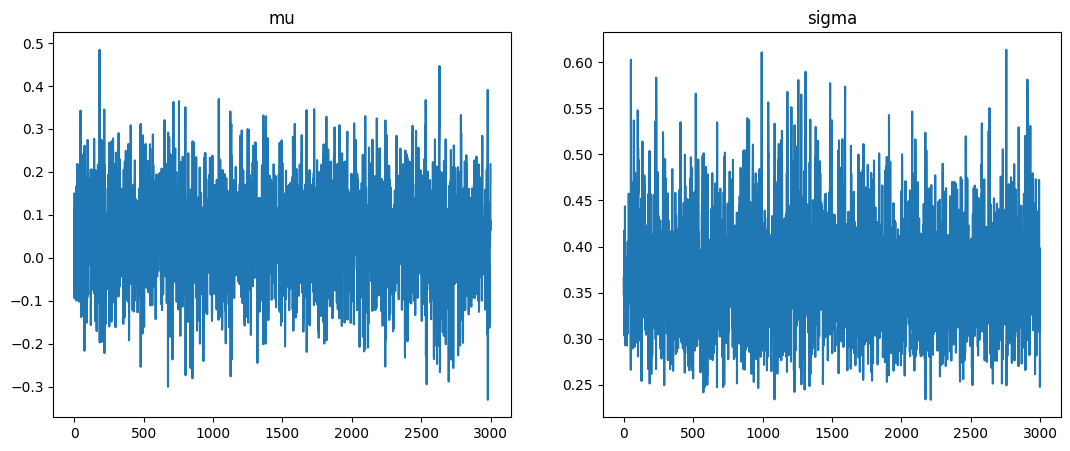

In [108]:
#| include: false

#Look at chain
fig, axes = plt.subplots(1,2, figsize=(13,5))

axes[0].plot(mcmc_hier.get_samples()['mu'])
axes[0].set_title("mu")
axes[1].plot(mcmc_hier.get_samples()['sigma'])
axes[1].set_title("sigma");

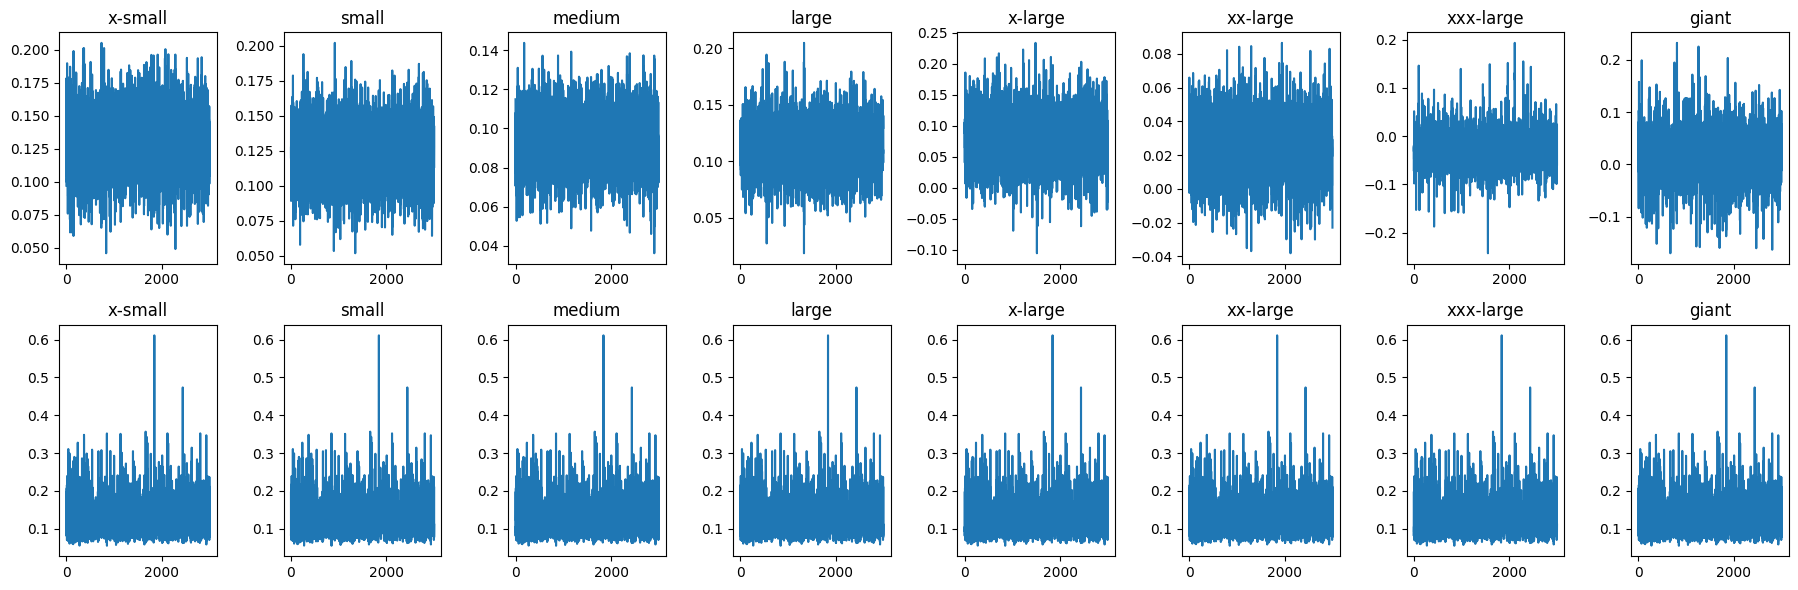

In [109]:
#| label: fig-trace-2
#| fig-cap: "2x8 trace plots of each class size. Top row are mu trace plots and bottom row are sigma trace plots"

#Plot chains of each class
fig, axes = plt.subplots(2,8, figsize=(18,6))

for i, ax in enumerate(axes.flatten()):
    if i < 8:
        ax.plot(mcmc_hier.get_samples()['class_mu'][:,i])
        ax.set_title(f"{groups[i]}")
    else:
        ax.plot(mcmc_hier.get_samples()['class_sigma'][:,i])
        ax.set_title(f"{groups[i-8]}")
        
fig.tight_layout()

From @fig-trace-2, we see that each mu and sigma trace plot per class appear to have good mixing and acceptable stationarity. Now that we have checked our MCMC diagnostics, we can begin exploring the generated posteriors from our model. @fig-dist-3 shows respective distributions for class size's mu parameter.

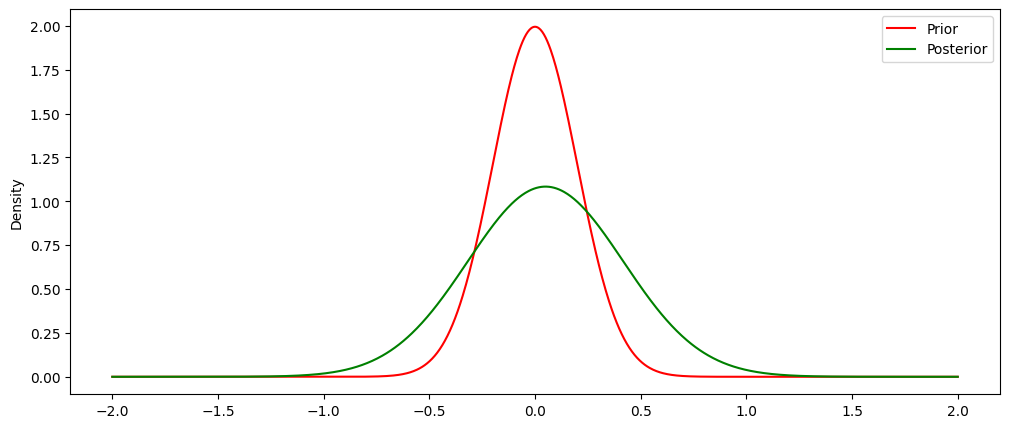

In [110]:
#| include: false

#Plot posterior for group level (based on MAP)
x = np.linspace(-2, 2, 1000)
prior_density_log = dist.Normal(0, 0.2).log_prob(x)
post_density_log = dist.Normal(mcmc_hier.get_samples()['mu'].mean(), mcmc_hier.get_samples()['sigma'].mean()).log_prob(x)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x, np.exp(prior_density_log), label='Prior', color='red')
ax.plot(x, np.exp(post_density_log), label='Posterior', color='green')
ax.set_ylabel("Density")
ax.legend();

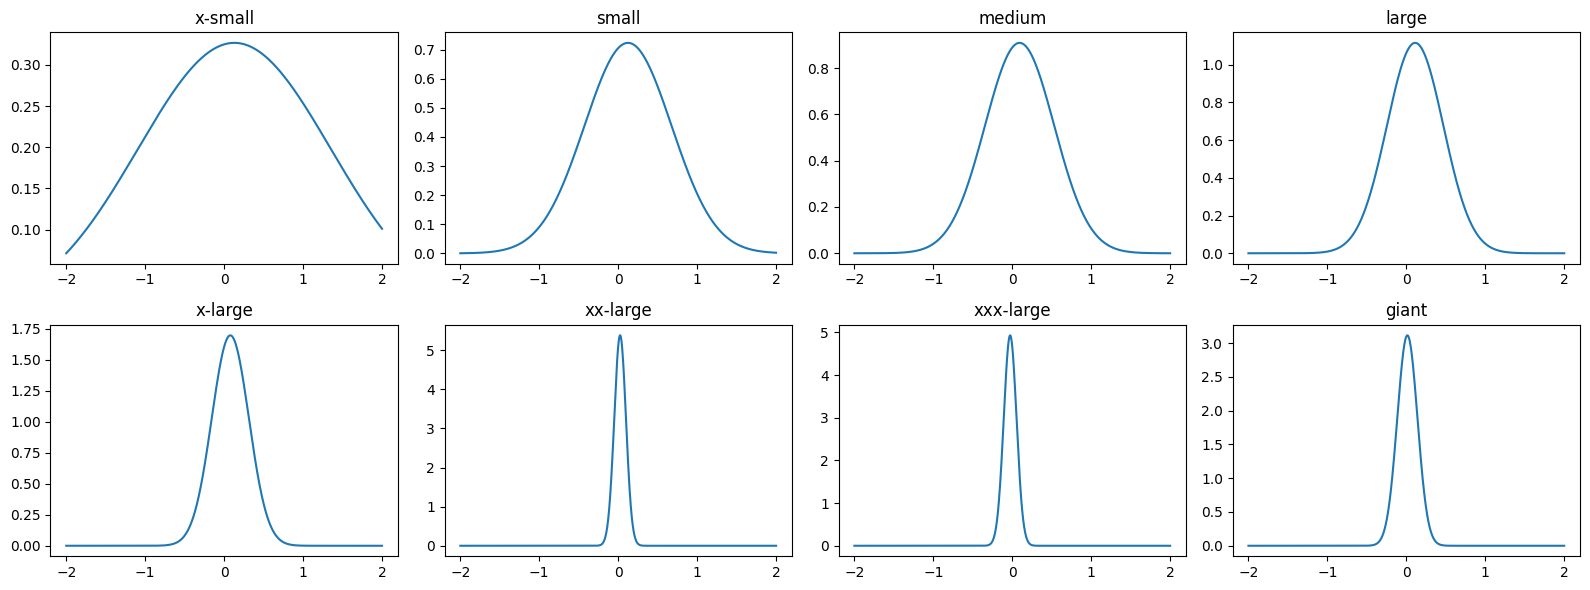

In [111]:
#| include: false

#Plot posterior for each class size (based on MAP)
fig, axes = plt.subplots(2,4, figsize=(16,6))

for i, ax in enumerate(axes.flatten()):
    post_density_log = dist.Normal(mcmc_hier.get_samples()['class_mu'][:, i].mean(), mcmc_hier.get_samples()['class_sigma'][:, i].mean()).log_prob(x)
    ax.plot(x, np.exp(post_density_log))
    ax.set_title(f"{groups[i]}")
    
fig.tight_layout()

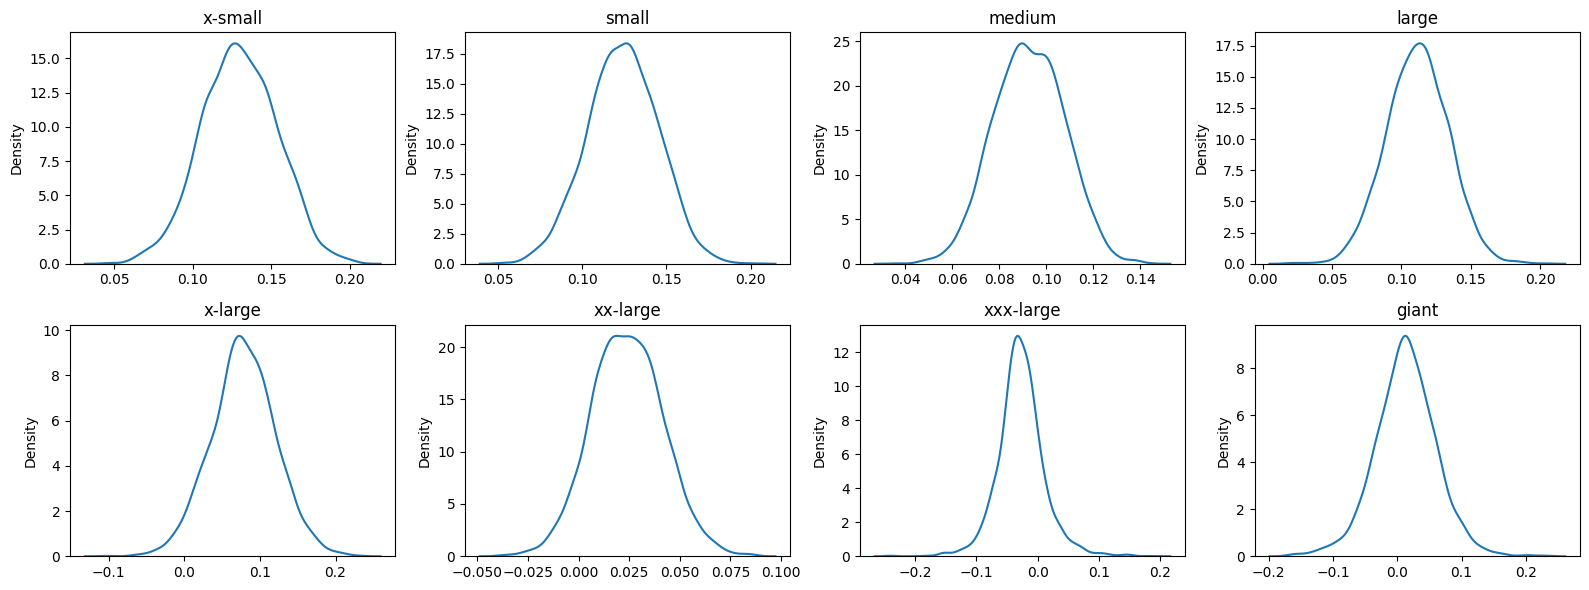

In [112]:
#| label: fig-dist-3
#| fig-cap: "2x4 grid of posterior distributions for each class size for parameter mu"

#Plot posterior of mu for each class size
fig, axes = plt.subplots(2,4, figsize=(16,6))

for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(mcmc_hier.get_samples()['class_mu'][:,i], ax=ax)
    ax.set_title(f"{groups[i]}")
    
fig.tight_layout()

@fig-dist-3 shows each class size mu parameter is approximately normally distributed. It is interesting to note where each distribution is centered. X-small is centered around .13 whereas larger classes like xxx-large are more centered around 0. It appears the there is a higher chance for smaller classes to have an increase in percent change in percent share of enrollment, whereas larger classes don't vary as much. Larger classes seem to stay most constant term by term, which is not too surprising. A similar plot for class size sigma parameter is found in @fig-dist-4.

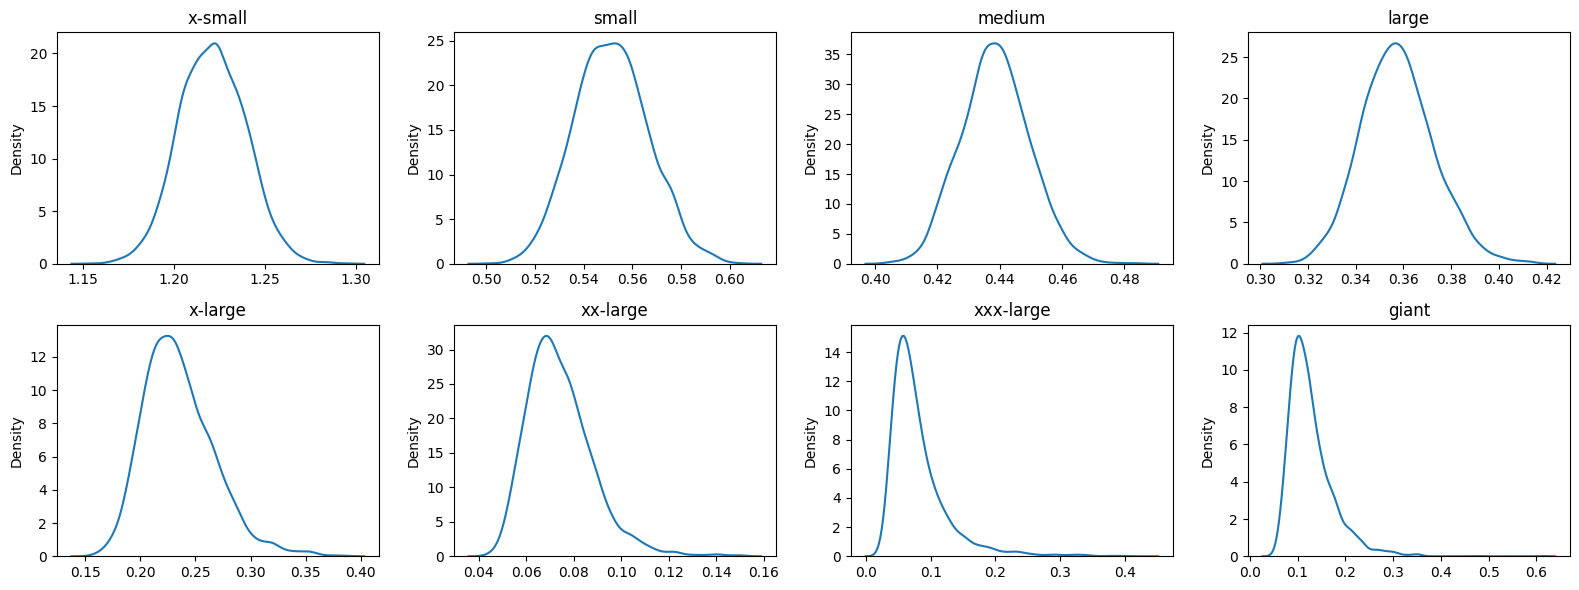

In [113]:
#| label: fig-dist-4
#| fig-cap: "2x4 grid of posterior distributions for each class size for parameter sigma"

#Plot posterior of sigma for each class size
fig, axes = plt.subplots(2,4, figsize=(16,6))

for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(mcmc_hier.get_samples()['class_sigma'][:,i], ax=ax)
    ax.set_title(f"{groups[i]}")
    
fig.tight_layout()

Once again, we notice that as the class size increases, the variability in sigma decreases.

### Posterior Predictive Distribution (Hierarchical Model)

Just as we performed in the first model of this analysis, we will generate a posterior predictive distribution to make class specific predictions. Since we built a hierarchical model, we will generate 8 separate PPDs for each class size. @fig-post-pred-2 shows the respective PPD for each class size.  

In [114]:
#Derive PPD from Bayesian model
post_hier_samples = mcmc_hier.get_samples()
ppd_hier = Predictive(hier_model, post_hier_samples)

In [115]:
#Generate synthetic data for PPD
np.random.seed(121)
hier_dict = {}

for i in range(len(np.unique(class_codes))):
    hier_dict[i] = np.random.normal(post_hier_samples['class_mu'][:,i], post_hier_samples['class_sigma'][:,i])

In [116]:
#Get PPD using synthetic data
ppd_hier_dict = {}

for i in range(len(np.unique(class_codes))):
    ppd_hier_dict[i] = ppd_hier(rng_key, np.array(i), hier_dict[i])

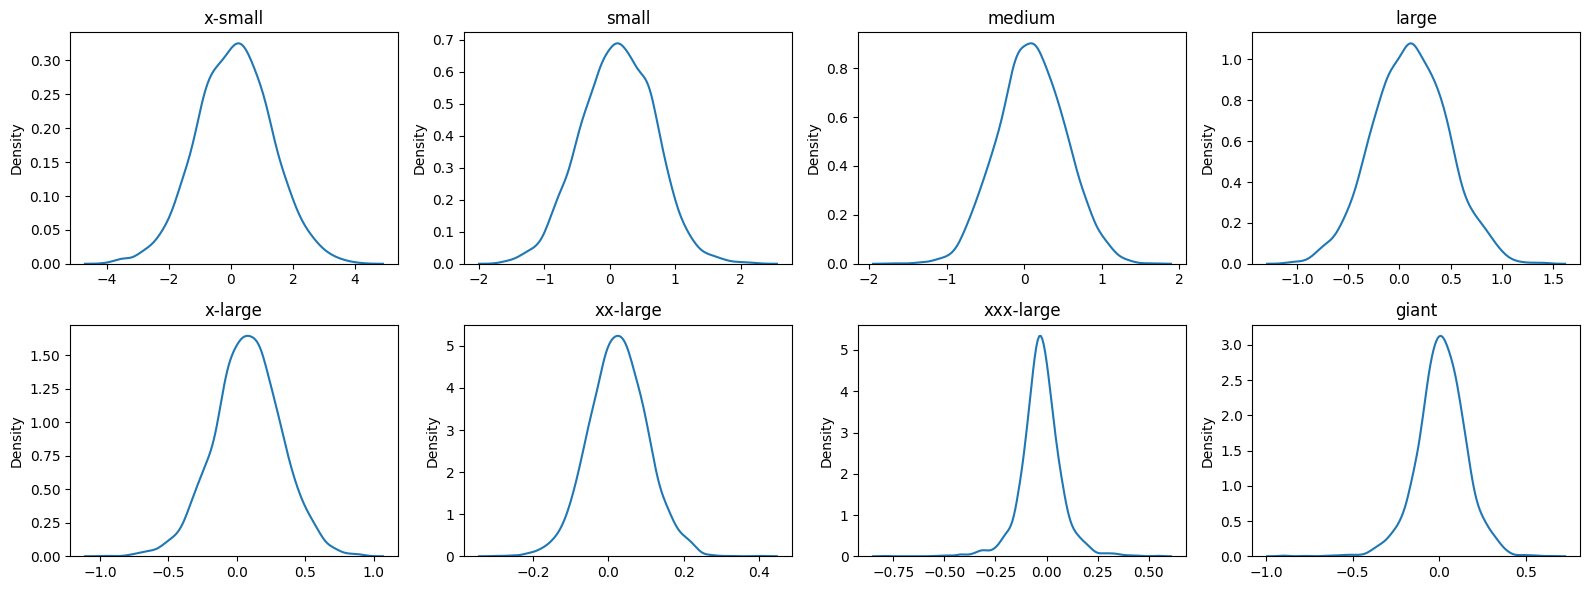

In [117]:
#| label: fig-post-pred-2
#| fig-cap: "2x4 grid of posterior predictive distributions for each class size"

#Plot PPD of each class size
fig, axes = plt.subplots(2,4, figsize=(16,6))

for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(ppd_hier_dict[i]['obs'][0,:], ax=ax)
    ax.set_title(f"{groups[i]}")
    
fig.tight_layout()

@fig-post-pred-2 shows just how variable the smaller classes can be. While the x-small through medium classes are all relatively centered around 0 (possibly due to scale of x axis), the variation in their predictions are fairly wide, especially in x-small classes. However, this should not be too problematic as an x-small class of size 10, even doubling in size, would only be 20. More than likely 1 professor and 1 TA would still be sufficient for this class. 

In contrast, we see that our larger classes do not have nearly as much predicted variability (a repeated theme we have mentioned a lot). This is good to know since these classes require the most resources. Since they appear to be reliably consistent, we can "trust" more in the predictions and know they will not be too far off from the usual. 

For example, take the class MATH 140 at TAMU. It is considered an intro level math course that many students must take in order to progress in their respective majors. It is considered a xxx-large class due to its popularity. Below is a point prediction for this class.

In [118]:
#Make prediction for MATH 140 for Fall 2023
ly_val_hier = (full_df_fall.query("Subject == 'MATH' and Course_Number == 140.0 and year == 2022")['pct_of_enroll'].values[0])
math_val = (full_df_fall.query("Subject == 'MATH' and Course_Number == 140.0 and year == 2023")['pct_enroll_yoy'].values[0])
map_xxxl = ppd_hier_dict[6]['obs'][0,:].mean()
print(f"Bayes Prediction for % change in pct_enroll: {map_xxxl:.3f}")
print(f"True Value for % change in pct_enroll: {math_val:.3f}")

Bayes Prediction for % change in pct_enroll: -0.027
True Value for % change in pct_enroll: 0.180


The model, due to its MAP, incorretly predicted the percent change in percent share of enrollment. However, point estimates in continuous predictions are rarely ever correct and thus require an interval prediction to ensure that our model at least captures the value within the interval. Below is a 95% PI for MATH 140. 

In [119]:
#Get 95% PI for MATH 140 for Fall 2023
lwr_hier = np.quantile(ppd_hier_dict[6]['obs'][0,:], .025)
upr_hier = np.quantile(ppd_hier_dict[6]['obs'][0,:], .975)
print(f"95% Prediction Interval for % change in pct_enroll: ({lwr_hier:.3f}, {upr_hier:.3f})")

95% Prediction Interval for % change in pct_enroll: (-0.229, 0.179)


As we can see, our interval would include the actual value (even if it is on the farthest outside). This indicates that the true value that occured is in fact a possibel anomaly. That is, it is a plausible value but is just not very likely. Nonetheless, because we used a Bayesian approach, we can probabilistically say that it is a possible value in the range of 95% probability. 

In order to properly predict the actual count of student enrollment by class, as mentioned previously, we use @eq-mod-1. Below is the predicted number of students, both point estimate and 95% PI.

In [120]:
#Combine predictions to get class specific prediction (point estimate)
pct_enroll_2023 = (full_df_fall.query("Subject == 'MATH' and Course_Number == 140.0 and year == 2023")['pct_of_enroll'].values[0])
print(f"Point Estimate for MATH 140: {round(bayes_pred) * ((map_xxxl + 1) * ly_val_hier):.0f}")
print(f"Actual Value for MATH 140: {true_pred * (pct_enroll_2023):.0f}")

Point Estimate for MATH 140: 3527
Actual Value for MATH 140: 4392


In [121]:
#Get 95% PI for class enrollment in MATH 140
print(f"95% Prediction Interval for MATH 140: ({round(bayes_pred) * ((lwr_hier + 1) * ly_val_hier):.0f}, {round(bayes_pred) * ((upr_hier + 1) * ly_val_hier):.0f})")

95% Prediction Interval for MATH 140: (2794, 4271)


As we can see, the 95% prediction interval is not far off from the actual value. The missing values would be trivial in such a large class forecast (at least for allocating university resources). While this test case has been informative, we should test another class to ensure our model is not always facing possible anomalies. To do this, we will look at MATH 308. Below is the point prediction for MATH 308.

In [122]:
#| include: false

full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0")

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,year,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
344,AT,MATH,308.0,True,926,99,371,362,94,2021,55400,0.016715,large,NaN
5290,AT,MATH,308.0,True,878,75,358,358,87,2022,56222,0.015617,large,-0.065699
7903,AT,MATH,308.0,True,967,70,430,391,76,2023,58933,0.016408,large,0.050702


In [123]:
#Make prediction for MATH 308 for Fall 2023
ly_val_hier = (full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0 and year == 2022")['pct_of_enroll'].values[0])
math_val = (full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0 and year == 2023")['pct_enroll_yoy'].values[0])
map_large = ppd_hier_dict[3]['obs'][0,:].mean()
print(f"Bayes Prediction for % change in pct_enroll: {map_large:.3f}")
print(f"True Value for % change in pct_enroll: {math_val:.3f}")

Bayes Prediction for % change in pct_enroll: 0.105
True Value for % change in pct_enroll: 0.051


As we can see, this time our model is over estimating the point estimate for percent change in percent share of enrollment. Our model predicts about a 10% increase in percent share of enrollment when the actual 2023 value was about 5%. While the point estimate is incorrect, it is not too far off in terms of practical prediction. Below is the corresponding 95% PI and resulting predictions from the point estimate and the PI.

In [124]:
#Get 95% PI for MATH 308 for Fall 2023
lwr_hier = np.quantile(ppd_hier_dict[3]['obs'][0,:], .025)
upr_hier = np.quantile(ppd_hier_dict[3]['obs'][0,:], .975)
print(f"95% Prediction Interval for % change in pct_enroll: ({lwr_hier:.3f}, {upr_hier:.3f})")

95% Prediction Interval for % change in pct_enroll: (-0.610, 0.832)


In [125]:
#Combine predictions to get class specific prediction (point estimate)
pct_enroll_2023 = (full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0 and year == 2023")['pct_of_enroll'].values[0])
print(f"Point Estimate for MATH 308: {round(bayes_pred) * ((map_large + 1) * ly_val_hier):.0f}")
print(f"Actual Value for MATH 308: {true_pred * (pct_enroll_2023):.0f}")

Point Estimate for MATH 308: 990
Actual Value for MATH 308: 967


In [126]:
#Get 95% PI for class enrollment in MATH 308
print(f"95% Prediction Interval for MATH 308: ({round(bayes_pred) * ((lwr_hier + 1) * ly_val_hier):.0f}, {round(bayes_pred) * ((upr_hier + 1) * ly_val_hier):.0f})")

95% Prediction Interval for MATH 308: (349, 1640)


As mentioned above, our point estimate from a practical point of view is not too far from the actual value and would not have any major ramifications from a resource allocation point of view. Our 95% PI though, it quite wide. While it is slightly narrower than our 95% PI for MATH 140, it is still a very large range that would not be too useful for forecasting. Nonetheless, this model has proven to be very useful in predicting (especially from a practical point of view) the percent change in percent share of enrollment. Combined with the first model, we have created a system for forecasting class enrollment down to specific class levels.

## Model 3: Bayesian Hierarchical Linear Model (college and class size)

While our Bayesian hierarchical model proved to be a useful model in our system for forecasting class enrollment, we believe we can do better given the amount of information we have. Another useful piece of information that we can utilize is college. Specifying to which college each class size pertains can help our model distinguish more clearly the percent change in percent share of enrollment for a specific class. Our model will then be an additive model, where we have two covariates (college and class size) predicting our response (% change in % share of enrollment). Below is the mathematical form of our model.

$$
Y_{ijk} = X_{ijk}\beta_{jk} + \epsilon_{ijk}
$$

$$
\epsilon_{ijk} \sim N(0, \sigma^{2}) 
$$

$$
Y_{jk} \sim MVN(X_{jk}\beta_{jk}, \sigma^{2}I) 
$$

$$
\beta_{j} \sim N(\mu_{m},\sigma_{m}^{2})  
$$

$$
\beta_{k} \sim N(\mu_{t}, \sigma_{t}^{2})
$$

$$
\mu_{m} \sim N(0, 0.5)
$$

$$
\sigma_{m} \sim HN(0.5)
$$

$$
\mu_{t} \sim N(0, 0.5)
$$

$$
\sigma_{t} \sim HN(0.5)
$$


After fitting our model to the data and using a NUTS sampler w/ 500 warmup and 5000 samples, we achieve the below results.

In [127]:
#Implement Hierarchical Linear Model 
def hier_model_v2(class_size, college, pct_change):
    #Initialize hyperparameter mu and sigma for class size effect
    mu_class = numpyro.sample('mu_class', dist.Normal(0, .5))
    sigma_class = numpyro.sample('sigma_class', dist.HalfNormal(.5))
    
    #Initialize hyperparameter mu and sigma for intercept for each class size
    mu_int = numpyro.sample('mu_int', dist.Normal(0, .01))
    sigma_int = numpyro.sample('sigma_int', dist.HalfNormal(.01))
    
    #Initialize hyperparameter mu and sigma for college effect
    mu_college = numpyro.sample('mu_college', dist.Normal(0, .5))
    sigma_college = numpyro.sample('sigma_college', dist.HalfNormal(.5))
    
    #Get number of class sizes
    n_sizes = np.unique(class_size).size
    
    #Get number of colleges
    n_colleges = np.unique(college).size
    
    #College-level parameters
    with numpyro.plate("colege", n_colleges):
        college_beta = numpyro.sample("college_beta", dist.Normal(mu_college, sigma_college))
    
    #Class-level parameters
    with numpyro.plate("class", n_sizes):
        class_beta = numpyro.sample("class_beta", dist.Normal(mu_class, sigma_class))
        class_int = numpyro.sample("class_int", dist.Normal(mu_int, sigma_int))
    
    #Initialize prior for sigma
    sigma = numpyro.sample('sigma', dist.HalfNormal(.5))
    
    #Perform linear regression
    mu = class_int[class_size] + (class_beta[class_size] * class_size) + (college_beta[class_size] * college)
    
    #Sample linear regression
    with numpyro.plate("data", class_size.size):
        numpyro.sample("obs", dist.Normal(mu, sigma), obs=pct_change)

In [128]:
#Drop nans from dataset for modeling
college_vals = full_df_fall.query("pct_enroll_yoy.notna()")['College'].values

In [129]:
#Transfrom college labels to numbers
college_encoder = LabelEncoder()
college_encoder.classes_ = np.array(['AC', 'AG', 'AT', 'BA', 'ED', 'EN', 'GB', 'GS', 'PH', 'PV'])
college_codes = college_encoder.transform(college_vals)

In [130]:
#Compile Hierarchical 2.0 model
nuts_kernel_hier_v2 = NUTS(hier_model_v2)
mcmc_hier_v2 = MCMC(nuts_kernel_hier_v2, num_warmup=500, num_samples=5000)
mcmc_hier_v2.run(rng_key, class_size=class_codes, college=college_codes, pct_change=pct_vals)

sample: 100%|███████████████████████████| 5500/5500 [00:17<00:00, 315.32it/s, 63 steps of size 7.87e-02. acc. prob=0.88]


In [131]:
#Print summary of v2
mcmc_hier_v2.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  class_beta[0]      0.03      0.04      0.03     -0.03      0.10   1825.25      1.00
  class_beta[1]      0.05      0.04      0.04     -0.01      0.10    688.67      1.00
  class_beta[2]      0.04      0.03      0.03     -0.01      0.07    752.82      1.00
  class_beta[3]      0.03      0.02      0.03     -0.01      0.07   1153.19      1.00
  class_beta[4]      0.03      0.03      0.03     -0.02      0.07   1733.09      1.00
  class_beta[5]      0.02      0.03      0.02     -0.03      0.07   1545.40      1.00
  class_beta[6]      0.02      0.03      0.02     -0.03      0.08   1703.07      1.00
  class_beta[7]      0.02      0.03      0.02     -0.03      0.07   1596.52      1.00
   class_int[0]      0.03      0.02      0.03     -0.00      0.07    517.34      1.00
   class_int[1]      0.02      0.02      0.02     -0.01      0.05   1396.59      1.00
   class_int[2]      0.01      0.02      0.01     -0.

Our output for each beta appears to indicate that we have acheived stationarity and good mixing. To verify this visually, we can look at @fig-trace-3.

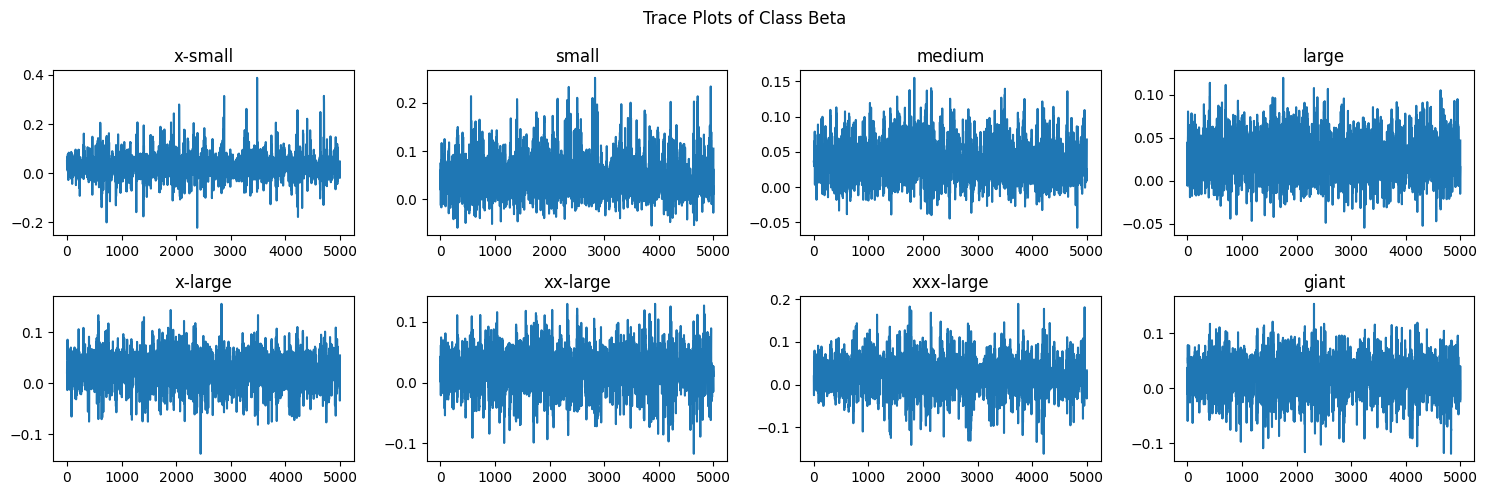

In [132]:
#| label: fig-trace-3
#| fig-cap: "2x4 grid of trace plots for each class size"

#Plot traceplots for each class beta
fig, ax = plt.subplots(2, 4, figsize=(15,5))

for i, ax in enumerate(ax.flatten()):
    ax.plot(mcmc_hier_v2.get_samples()['class_beta'][:,i])
    ax.set_title(f"{class_encoder.classes_[i]}")

fig.suptitle("Trace Plots of Class Beta")
fig.tight_layout();

The betas for each class size level appear to be well mixed and stationary. To verify the betas for each college, we can look at @fig-trace-4.

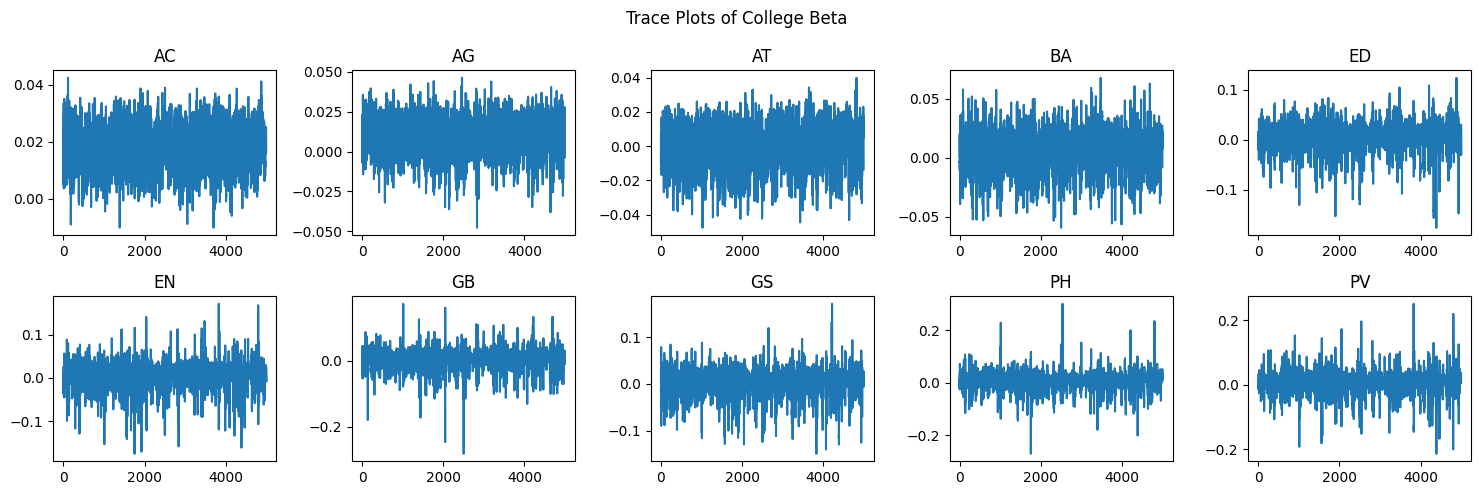

In [133]:
#| label: fig-trace-4
#| fig-cap: "2x4 grid of trace plots for each college"

#Plot traceplots for each college beta
fig, ax = plt.subplots(2, 5, figsize=(15,5))

for i, ax in enumerate(ax.flatten()):
    ax.plot(mcmc_hier_v2.get_samples()['college_beta'][:,i])
    ax.set_title(f"{college_encoder.classes_[i]}")

fig.suptitle("Trace Plots of College Beta")
fig.tight_layout();

Just as with @fig-trace-3, we can see that each college appears to have reached appropriate stationarity and mixing. Now that we have verified that our sampler functioned well, we can begin investigating the posterior distributions. @fig-dist-5 shows the posterior distributions of each class size and @fig-dist-6 shows the posterior distributions for each college.

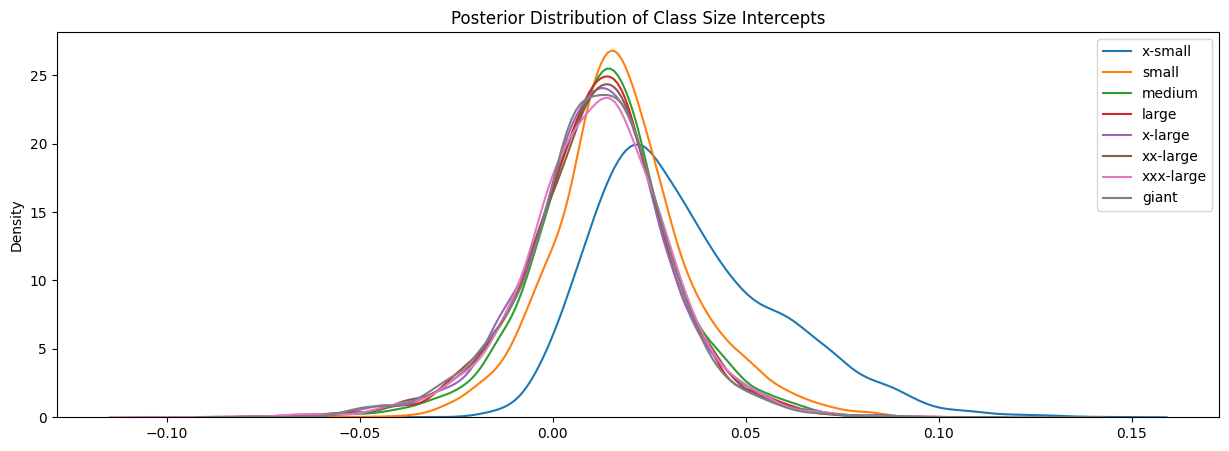

In [134]:
#| include: false

#Plot posterior of intercept for each class
fig, ax = plt.subplots(figsize=(15,5))

for i in range(len(class_encoder.classes_)):
    sns.kdeplot(mcmc_hier_v2.get_samples()['class_int'][:,i], label=f"{class_encoder.classes_[i]}")

ax.set_title("Posterior Distribution of Class Size Intercepts")
plt.legend();

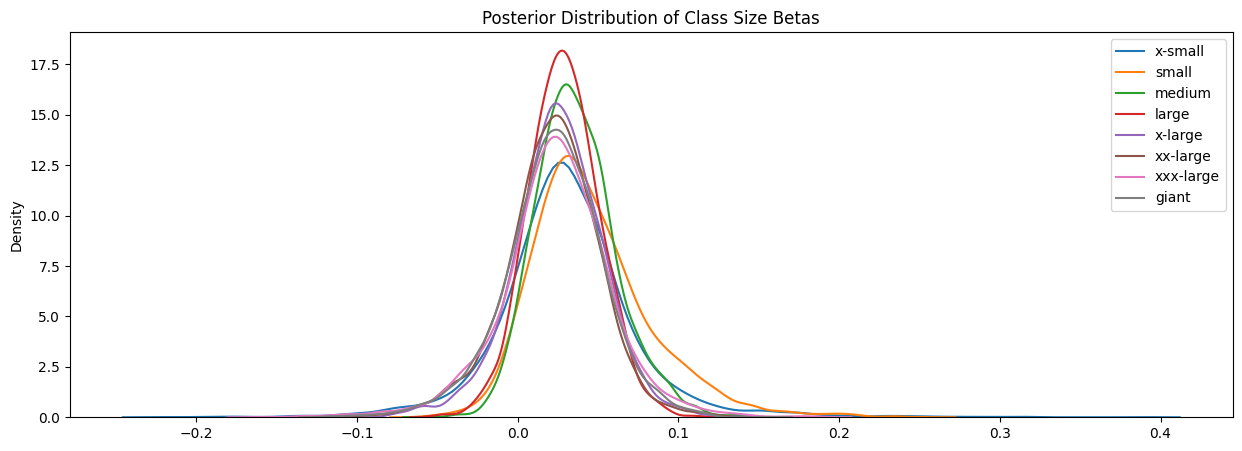

In [135]:
#| label: fig-dist-5
#| fig-cap: "Posterior distributions of each class size beta"

#Plot posterior of beta for each class
fig, ax = plt.subplots(figsize=(15,5))

for i in range(len(class_encoder.classes_)):
    sns.kdeplot(mcmc_hier_v2.get_samples()['class_beta'][:,i], label=f"{class_encoder.classes_[i]}", ax=ax)

ax.set_title("Posterior Distribution of Class Size Betas")    
plt.legend();

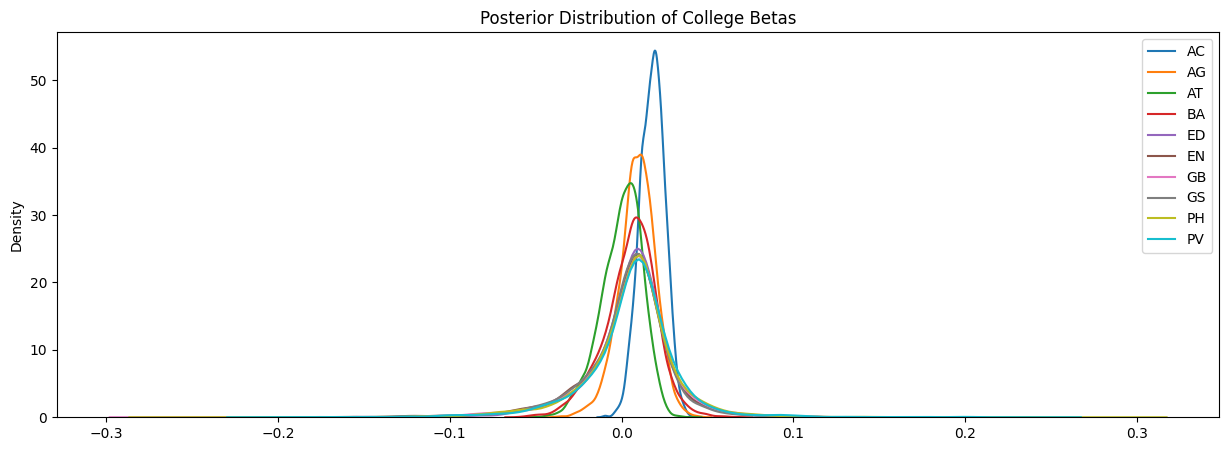

In [136]:
#| label: fig-dist-6
#| fig-cap: "Posterior distributions of each college beta"

#Plot posterior of beta for each college
fig, ax = plt.subplots(figsize=(15,5))

for i in range(len(college_encoder.classes_)):
    sns.kdeplot(mcmc_hier_v2.get_samples()['college_beta'][:,i], label=f"{college_encoder.classes_[i]}", ax=ax)

ax.set_title("Posterior Distribution of College Betas")    
plt.legend();

It is interesting to note that in both @fig-dist-5 and @fig-dist-6, we see that most of the distributions are relatively centered around the point. The distinguishing feature for each distribution is the respective spread. 

Just as we performed for our first hierarchical model, we can perform predictions by generating a posterior predictive distribution (see @eq-pred-1). We will first explore the predictions with this model for MATH 308 and compare it to our predictions from our first hierarchical model. The results are shown below.

In [137]:
#Get prediction for MATH 308
pred_lm = (mcmc_hier_v2.get_samples()['class_int'][:,3] + 
           mcmc_hier_v2.get_samples()['class_beta'][:,3] + 
           mcmc_hier_v2.get_samples()['college_beta'][:,2])

In [138]:
#| include: false

#View MATH 308
(full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,year,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
344,AT,MATH,308.0,True,926,99,371,362,94,2021,55400,0.016715,large,NaN
5290,AT,MATH,308.0,True,878,75,358,358,87,2022,56222,0.015617,large,-0.065699
7903,AT,MATH,308.0,True,967,70,430,391,76,2023,58933,0.016408,large,0.050702


In [139]:
#Get mean, 95% PI of pred_lm and compare to actual
true_val = (full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0 and year == 2023")['pct_enroll_yoy'].values[0])
ly_val = (full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0 and year == 2022")['pct_of_enroll'].values[0])
true_enroll_class = (full_df_fall.query("Subject == 'MATH' and Course_Number == 308.0 and year == 2023")['count_students'].values[0])
lwr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .025)) * bayes_pred)
upr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .975)) * bayes_pred)

print(f"Mean of pred_lm: {pred_lm.mean().tolist():.4f}")
print(f"95% PI of pred_lm: ({np.quantile(pred_lm, .025):.4f}, {np.quantile(pred_lm, .975):.4f})")
print(f"True value of pct_enroll_yoy: {true_val:.4f}")
print(f"Predicted Number of Students: {(ly_val * (1 + pred_lm.mean()) * bayes_pred):.0f}")
print(f"95% PI of Number of Students: ({lwr_95_pred:.0f}, {upr_95_pred:.0f})")
print(f"True Number of Students: {true_enroll_class}")

Mean of pred_lm: 0.0403
95% PI of pred_lm: (-0.0108, 0.0907)
True value of pct_enroll_yoy: 0.0507
Predicted Number of Students: 932
95% PI of Number of Students: (886, 977)
True Number of Students: 967


The very notable change in our prediction from our hierarchical linear model is that our PI range has shrunk significantly. Instead of the upper limit being close to .8, our upper limit of our 95% PI is approximately .09. That is a significant improvement! Our new hierarchical model also still contains the true value of percent change in percent share of enrollment. As we can see from above, our 95% PI for the predicted number of students is significantly better than before and would be of much better use practically for forecasting. We can perform this exercise again with predictions for MATH 140. Below are our results.

In [140]:
#Get prediction for MATH 140
pred_lm = (mcmc_hier_v2.get_samples()['class_int'][:,6] + 
           mcmc_hier_v2.get_samples()['class_beta'][:,6] + 
           mcmc_hier_v2.get_samples()['college_beta'][:,2])

In [141]:
#Get mean of pred_lm
true_val = (full_df_fall.query("Subject == 'MATH' and Course_Number == 140.0 and year == 2023")['pct_enroll_yoy'].values[0])
ly_val = (full_df_fall.query("Subject == 'MATH' and Course_Number == 140.0 and year == 2022")['pct_of_enroll'].values[0])
true_enroll_class = (full_df_fall.query("Subject == 'MATH' and Course_Number == 140.0 and year == 2023")['count_students'].values[0])
lwr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .025)) * bayes_pred)
upr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .975)) * bayes_pred)

print(f"Mean of pred_lm: {pred_lm.mean().tolist():.4f}")
print(f"95% PI of pred_lm: ({np.quantile(pred_lm, .025):.4f}, {np.quantile(pred_lm, .975):.4f})")
print(f"True value of pct_enroll_yoy: {true_val:.4f}")
print(f"Predicted Number of Students: {(ly_val * (1 + pred_lm.mean()) * bayes_pred):.0f}")
print(f"95% PI of Number of Students: ({lwr_95_pred:.0f}, {upr_95_pred:.0f})")
print(f"True Number of Students: {true_enroll_class}")

Mean of pred_lm: 0.0354
95% PI of pred_lm: (-0.0483, 0.1073)
True value of pct_enroll_yoy: 0.1796
Predicted Number of Students: 3751
95% PI of Number of Students: (3448, 4012)
True Number of Students: 4392


We once again see a shrunken PI interval for this class. However, because the true percent change in percent enrollment was a large anomaly, our newly shrunken 95% PI does not capture our true percent change in percent share of enrollment. Nonetheless, the 95% PI can still be of practical use as it is not too far off from the true number of predicted students. 

# Conclusion

Our analysis showed that a good way to forecast student enrollment to a class specific level is well done using a Bayesian hierarchical linear model. Utilizing the information of class size and college provided the model a good way of approximating the percent change in percent share of enrollment. By approaching this forecasting problem from a percent change perspective, we demonstrated that these changes approximately follow a normal distribution, depending on the class size and college mixture. Additional data points should be investigated to determine if they would be viable additions to our model, as well as more thorough investigations on how to set priors and delineate between class sizes. Overall, we have proven that it is possible to forecast student enrollment down to the class level using Bayesian methods.

In [142]:
#| include: false

#View STAT 182
full_df_fall.query("Subject == 'STAT' and Course_Number == 182.0")

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,year,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
122,AT,STAT,182.0,True,40,28,2,9,1,2021,55400,0.000722,x-small,NaN
5065,AT,STAT,182.0,True,87,74,4,7,2,2022,56222,0.001547,small,1.143200
7671,AT,STAT,182.0,True,104,93,1,9,1,2023,58933,0.001765,medium,0.140412


In [143]:
#| include: false

#Get prediction for STAT 182
pred_lm = (mcmc_hier_v2.get_samples()['class_int'][:,1] + 
           mcmc_hier_v2.get_samples()['class_beta'][:,1] + 
           mcmc_hier_v2.get_samples()['college_beta'][:,2])

In [144]:
#| include: false

#Get mean of pred_lm
true_val = (full_df_fall.query("Subject == 'STAT' and Course_Number == 182.0 and year == 2023")['pct_enroll_yoy'].values[0])
ly_val = (full_df_fall.query("Subject == 'STAT' and Course_Number == 182.0 and year == 2022")['pct_of_enroll'].values[0])
true_enroll_class = (full_df_fall.query("Subject == 'STAT' and Course_Number == 182.0 and year == 2023")['count_students'].values[0])
lwr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .025)) * bayes_pred)
upr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .975)) * bayes_pred)

print(f"Mean of pred_lm: {pred_lm.mean().tolist():.4f}")
print(f"95% PI of pred_lm: ({np.quantile(pred_lm, .025):.4f}, {np.quantile(pred_lm, .975):.4f})")
print(f"True value of pct_enroll_yoy: {true_val:.4f}")
print(f"Predicted Number of Students: {(ly_val * (1 + pred_lm.mean()) * bayes_pred):.0f}")
print(f"95% PI of Number of Students: ({lwr_95_pred:.0f}, {upr_95_pred:.0f})")
print(f"True Number of Students: {true_enroll_class}")

Mean of pred_lm: 0.0639
95% PI of pred_lm: (0.0030, 0.1489)
True value of pct_enroll_yoy: 0.1404
Predicted Number of Students: 94
95% PI of Number of Students: (89, 102)
True Number of Students: 104


In [145]:
#| include: false

#View ENGR 102
(full_df_fall.query("Subject == 'ENGR' and Course_Number == 102.0"))

,College,Subject,Course_Number,is_fall,count_students,count_freshmen,count_sophomore,count_junior,count_senior,year,total_enroll,pct_of_enroll,class_size,pct_enroll_yoy
819,EN,ENGR,102.0,True,4616,4549,51,11,5,2021,55400,0.083321,giant,NaN
5788,EN,ENGR,102.0,True,5020,4945,48,19,8,2022,56222,0.089289,giant,0.071621
8397,EN,ENGR,102.0,True,4933,4869,41,15,8,2023,58933,0.083705,giant,-0.062535


In [146]:
#| include: false

#Get prediction for ENGR 102
pred_lm = (mcmc_hier_v2.get_samples()['class_int'][:,7] + 
           mcmc_hier_v2.get_samples()['class_beta'][:,7] + 
           mcmc_hier_v2.get_samples()['college_beta'][:,5])

In [147]:
#| include: false

#Get mean of pred_lm
true_val = (full_df_fall.query("Subject == 'ENGR' and Course_Number == 102.0 and year == 2023")['pct_enroll_yoy'].values[0])
ly_val = (full_df_fall.query("Subject == 'ENGR' and Course_Number == 102.0 and year == 2022")['pct_of_enroll'].values[0])
true_enroll_class = (full_df_fall.query("Subject == 'ENGR' and Course_Number == 102.0 and year == 2023")['count_students'].values[0])
lwr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .025)) * bayes_pred)
upr_95_pred = (ly_val * (1 + np.quantile(pred_lm, .975)) * bayes_pred)

print(f"Mean of pred_lm: {pred_lm.mean().tolist():.4f}")
print(f"95% PI of pred_lm: ({np.quantile(pred_lm, .025):.4f}, {np.quantile(pred_lm, .975):.4f})")
print(f"True value of pct_enroll_yoy: {true_val:.4f}")
print(f"Predicted Number of Students: {(ly_val * (1 + pred_lm.mean()) * bayes_pred):.0f}")
print(f"95% PI of Number of Students: ({lwr_95_pred:.0f}, {upr_95_pred:.0f})")
print(f"True Number of Students: {true_enroll_class}")

Mean of pred_lm: 0.0367
95% PI of pred_lm: (-0.0499, 0.1097)
True value of pct_enroll_yoy: -0.0625
Predicted Number of Students: 5308
95% PI of Number of Students: (4865, 5682)
True Number of Students: 4933


In [148]:
#Generate predictions for each class-college size
pred_dict = {}

for i in range(class_codes.max() + 1):
    for j in range(college_codes.max() + 1):
        pred_dict[i,j] = (mcmc_hier_v2.get_samples()['class_int'][:,i] + 
           mcmc_hier_v2.get_samples()['class_beta'][:,i] + 
           mcmc_hier_v2.get_samples()['college_beta'][:,j])

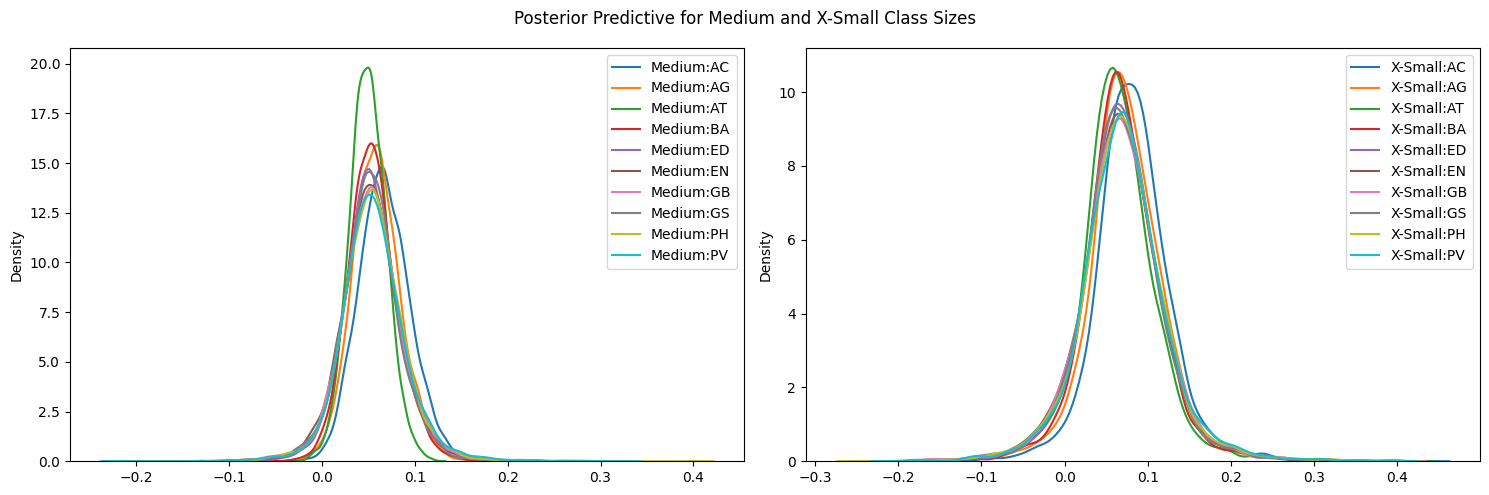

In [149]:
#| include: false

#Plot PPD for medium and x-small class size for each college
fig, ax = plt.subplots(1, 2, figsize=(15,5))

for i in range(len(college_encoder.classes_)):
    sns.kdeplot(pred_dict[2,i], label=f"Medium:{college_encoder.classes_[i]}", ax=ax[0])
    sns.kdeplot(pred_dict[0,i], label=f"X-Small:{college_encoder.classes_[i]}", ax=ax[1])


fig.suptitle("Posterior Predictive for Medium and X-Small Class Sizes")
ax[0].legend()
ax[1].legend()

fig.tight_layout();